**Carlos Iván Canto Varela\
Matemáticas aplicadas\
Facultad de Ciencias, UNAM**



---
---
# Pronóstico de variaciones en el PIB usando redes neuronales y riesgos estadísticos
---
---


En este código se implementan los modelos de predicción descritos en la sección de Aplicación.



---
## Preparación del espacio de trabajo

In [1]:
#%pip install prettytable numpy pandas torch torchinfo scikit-learn ISLP openpyxl lightning[extra] dtreeviz yfinance
# Visualización de árboles.
import dtreeviz
# Tablas para impresiones.
from prettytable import PrettyTable
# Operaciones y manejo de datos.
import numpy as np, pandas as pd, os
# Gráficas
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from datetime import datetime
# Estandarización.
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
# Validación cruzada.
from sklearn.model_selection import KFold
# Regresion KNN.
from sklearn.neighbors import KNeighborsRegressor
# Gradiente potenciado.
from sklearn.ensemble import GradientBoostingRegressor
# Redes neuronales.
import torch
from torch import nn
# Conjuntos de datos.
#from torch.utils.data import TensorDataset
# Medidas de poder predicción.
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score)
# Resumen de modelos.
from torchinfo import summary
#from pytorch_lightning import Trainer
# Semilla para replicación.
from pytorch_lightning import seed_everything
# Auxiliares.
#from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)
# Advertencias y outputs
import warnings
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
os.environ['PATH'] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
# Guardado de resultados.
import pickle
#import logging
#logging.getLogger('pytorch_lightning.utilities.rank_zero').setLevel(logging.WARNING)

---
## Preliminares

### Datos

In [2]:
data = pd.read_excel(os.getcwd() + '\\Data.xlsx', sheet_name = 'Data')
targets = data.iloc[:-1, 1]

dataframe = data
dataframe['quarter'] = dataframe.apply(
  lambda row: (row.date.month - 1)//3 + 1, axis = 1)

dataframe = dataframe.join(
  ('Q' + dataframe.quarter.astype(str)
   ).str.get_dummies().replace({'true':1, 'false':0}))
dataframe.drop('quarter', axis = 1, inplace = True)

for col in list(dataframe.columns):
  newcol = np.zeros(dataframe.shape[0]) * np.nan
  newcol[1:] = dataframe[col].values[:-1]
  dataframe.insert(len(dataframe.columns),
                   '{0}_{1}'.format(col, 1), newcol)

dataframe.drop(index = dataframe.index[0], axis = 0, inplace = True)
dataframe = dataframe.reset_index(drop = True)

### Funciones auxiliares

#### msMAPE

In [3]:
"""
Función para calcular el error porcentual absoluto simétrico medio modificado.

Parámetros:
  preds:  Arreglo
            Predicciones.
  obs:    Arreglo
            Observaciones.

Regresa:
  val:  Flotante
            Valor del EPASMm buscado.
"""

def msMAPE(preds, obs):
  val = 2/len(obs) * (np.abs(preds - obs) / (np.abs(obs + preds))
                        ).sum()
  return val

#### Preprocessing

In [4]:
"""
Función para realizar el preprocesamiento de datos para las redes LSTM.

Parámetros:
  dataframer: DataFrame
                Atributos de entrada.
  targets:    DataFrame
                Variable objetivo de entrada.
  looped:     Tupla
                Indicador de la iteración en los ciclos externos e
                internos.

Regresa:
  X_train: DataFrame
             Atributos para el entrenamiento.
  Y_train: DataFrame
             Variables objetivo para el entrenamiento.
  X_test:  DataFrame
             Atributos para la evaluación.
  Y_test:  DataFrame
             Variables objetivo para la evaluación.
"""

def preprocessing(dataframer, targets, looped):

  dataframe = dataframer
  # Ciclo externo.
  partitions = list()
  for i, (x, y) in enumerate(KFold(n_splits = 5).split(dataframe)):
    partitions.append((x, y))
  part, _ = partitions[looped[0]]

  train_targets = targets[part].reset_index(drop = True)
  test_targets = targets[~targets.index.isin(part)
                         ].reset_index(drop = True)
  
  # Recuperación de riesgos previamente realizados.
  if looped[1] is None:
    risks = pd.read_csv(os.getcwd() + '\\Risks\\risks_' +
                        str(looped[0]) + '.csv')
  else:
    risks = pd.read_csv(os.getcwd() + '\\Risks\\risks_' +
                        str(looped[0]) + '_' + str(looped[1]) + '.csv')
    partitions = list()
    for i, (x, y) in enumerate(KFold(n_splits = 5).split(
      dataframe.iloc[part, :].reset_index(drop = True))):
      partitions.append((x, y))
    part, _ = partitions[looped[1]]
    test_targets = train_targets[~train_targets.index.isin(part)
                                 ].reset_index(drop = True)
    train_targets = train_targets[part].reset_index(drop = True)

  risks['date'] = pd.to_datetime(risks['date'])
  risks = risks.iloc[:, 0:5]

  # Preprocesamiento.
  dataframe = dataframe.merge(risks, on = 'date', how = 'inner')
  dataframe = dataframe.iloc[:, -(int(len(dataframe.columns)/2) + 1):]
  dataframe.columns = [col.split('_')[0] for col in dataframe.columns]
  dataframe = dataframe[
    [col for col in dataframe if col not in ['Q1', 'Q2', 'Q3', 'Q4']] +
    ['Q1', 'Q2', 'Q3', 'Q4']]
  cols = dataframe.columns

  X_train = dataframe.iloc[part, :].reset_index(drop = True)
  #X_test = dataframe.iloc[~dataframe.index.isin(part)].reset_index(drop = True)

  # Estandarización de atributos númericos.
  std_cols = cols[0:-4]
  std = ColumnTransformer([('placeholder', StandardScaler(),
                            std_cols)], remainder = 'passthrough')
  X_train = pd.DataFrame(std.fit_transform(X_train), columns = cols)
  #X_test = pd.DataFrame(std.fit_transform(X_test), columns = cols)
  X_test = pd.DataFrame(std.fit_transform(dataframe), columns = cols).iloc[~dataframe.index.isin(part)
                          ].reset_index(drop = True)
  # Rezagos.
  for lag in range(1, 6):
    for col in list(cols):
      newcol_train = np.zeros(X_train.shape[0]) * np.nan
      newcol_train[lag:] = X_train[col].values[:-lag]
      X_train.insert(
        len(X_train.columns), '{0}_{1}'.format(col, 6 - lag),
        newcol_train)
      newcol_test = np.zeros(X_test.shape[0]) * np.nan
      newcol_test[lag:] = X_test[col].values[:-lag]
      X_test.insert(len(X_test.columns),
                    '{0}_{1}'.format(col, 6 - lag), newcol_test)
  X_train = X_train.dropna().drop(columns = list(cols))
  X_test = X_test.dropna().drop(columns = list(cols))
  Y_train = train_targets[5:].reset_index(drop = True)
  Y_test = test_targets[5:].reset_index(drop = True)

  ordered_cols = []
  for lag in range(1, 6):
    for col in cols:
      ordered_cols.append('{0}_{1}'.format(col, abs(lag - 6)))
  X_train = X_train.reindex(columns = ordered_cols).reset_index(drop = True)
  X_test = X_test.reindex(columns = ordered_cols).reset_index(drop = True)

  return X_train, Y_train, X_test, Y_test

#### KNN Preprocessing

In [5]:
"""
Función para realizar el preprocesamiento de datos para la regresión
KNN.

Parámetros:
  dataframer:   DataFrame
                  Datos en bruto.
  targets:      DataFrame
                  Variable objetivo de entrada.
  looped:       Tupla
                  Indicador de la iteración en los ciclos externos e internos.
Regresa:
  X_train: DataFrame
             Atributos para el entrenamiento.
  Y_train: DataFrame
             Variables objetivo para el entrenamiento.
  X_test:  DataFrame
             Atributos para la evaluación.
  Y_test:  DataFrame
             Variables objetivo para la evaluación.
"""

def KNNr_preprocessing(dataframer, targets, looped):

  dataframe = dataframer['GDPv'][:-1]
  partitions = list()
  for i, (x, y) in enumerate(KFold(n_splits = 5).split(dataframe)):
    partitions.append((x, y))
  part, _ = partitions[looped[0]]

  train_targets = targets[part].reset_index(drop = True)
  test_targets = targets[~targets.index.isin(part)
                         ].reset_index(drop = True)
  test_targets = test_targets[:-1]
  X_train = dataframe[part].reset_index(drop = True)
  X_test = dataframe[~dataframe.index.isin(part)
                     ].reset_index(drop = True)

  if looped[1] is None:
    pass
  else:
    partitions = list()
    for i, (x, y) in enumerate(
      KFold(n_splits = 5).split(
        dataframe[part].reset_index(drop = True))):
      partitions.append((x, y))
    part, _ = partitions[looped[1]]
    test_targets = train_targets[~train_targets.index.isin(part)
                                 ].reset_index(drop = True)
    train_targets = train_targets[part].reset_index(drop = True)
    X_test = X_train[~X_train.index.isin(part)
                     ].reset_index(drop = True)
    X_train = X_train[part].reset_index(drop = True)    
  
  X_train = X_train.to_frame()
  X_test = X_test.to_frame()

  # Rezagos.
  for lag in range(1, 6):
    newcol_train = np.zeros(X_train.shape[0]) * np.nan
    newcol_train[lag:] = X_train['GDPv'].values[:-lag]
    X_train.insert(len(X_train.columns),
                   '{0}_{1}'.format('GDPv', 6 - lag), newcol_train)
    newcol_test = np.zeros(X_test.shape[0]) * np.nan
    newcol_test[lag:] = X_test['GDPv'].values[:-lag]
    X_test.insert(len(X_test.columns),
                  '{0}_{1}'.format('GDPv', 6 - lag), newcol_test)
  X_train = X_train.dropna().drop(columns = 'GDPv')
  X_test = X_test.dropna().drop(columns = 'GDPv')

  Y_train = train_targets[5:].reset_index(drop = True).to_frame()
  Y_test = test_targets[5:].reset_index(drop = True).to_frame()

  ordered_cols = []
  for lag in range(1, 6):
    ordered_cols.append('{0}_{1}'.format('GDPv', lag))
  X_train = X_train.reindex(columns = ordered_cols)
  X_test = X_test.reindex(columns = ordered_cols)

  X_train = X_train.reset_index(drop = True)
  X_test = X_test.reset_index(drop = True)

  return X_train, Y_train, X_test, Y_test

#### Parameter counting

In [6]:
"""
Función para delinear y contar los parámetros de una red LSTM.

Parámetros:
  model: Modelo
           Modelo a analizar.
Regresa:
  None
"""

def count_parameters(model):
  table = PrettyTable(["Modules", "Parameters"])
  total_params = 0
  for name, parameter in model.named_parameters():
      if not parameter.requires_grad:
        continue
      params = parameter.numel()
      table.add_row([name, params])
      total_params += params
  print(table)
  print(f"Total parameters: {total_params}")
  return None

#### Network training

In [7]:
"""
Función para detallar y realizar el entrenamiento de las redes LSTM.

Parámetros:
  model:     Modelo
               Modelo LSTM a entrenar.
  n_epochs:  Entero
               Número de épocas a utilizar.
  optimizer: Optimizador
               Optimizador a implementar.
  X_train:   Tensor
               Atributos para el entrenamiento.
  Y_train:   Tensor
               Variable objetivo para el entrenamiento.
  X_test:    Tensor
               Atributos para la evaluación.
  Y_test:    Tensor
               Variable objetivo para la evaluación.
  save:      Booleano
               Indicador para guardado de información.
Regresa:
  LSTM_evolution: DataFrame
                    Evolución de los errores de entrenamiento y evaluación a lo largo de las épocas.
"""

def nn_train(model, n_epochs, optimizer, X_train, Y_train, X_test, Y_test, save):
  LSTM_evolution = pd.DataFrame()
  for epoch in range(n_epochs):
    model.train()
    outputs = model.forward(X_train)
    optimizer.zero_grad()
    loss = torch.nn.MSELoss()(outputs, Y_train)
    loss.backward()
    optimizer.step()
    model.eval()
    test_preds = model(X_test)
    test_loss = torch.nn.MSELoss()(test_preds, Y_test)
    if save == True:
      LSTM_evolution = LSTM_evolution._append(
        pd.Series(
          [epoch, loss.item(), test_loss.item()]
          ).astype(float), ignore_index = True)
      if epoch % 100 == 0:
        print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                  loss.item(),
                                                                  test_loss.item()))
  if save == True:
    LSTM_evolution.columns = ['epoch', 'train_MSE', 'test_MSE']
  return(LSTM_evolution)

### Definición de modelos LSTM

In [8]:
# LSTM por defecto.
class LSTM_Default(nn.Module):
  def __init__(self):
    super(LSTM_Default, self).__init__()
    self.lstm = nn.LSTM(input_size = 31, hidden_size = 30,
                        num_layers = 1, batch_first = True)
    self.dense = nn.Linear(30, 1)
  def forward(self , x):
    h0 = torch.zeros(1, x.size(0), 30).to(x.device)
    c0 = torch.zeros(1, x.size(0), 30).to(x.device)
    _, (x, _) = self.lstm(x, (h0, c0))
    x = x.view(-1, 30)
    return self.dense(x)

# LSTM con más células.
class LSTM_Wide(nn.Module):
  def __init__(self):
    super(LSTM_Wide, self).__init__()
    self.lstm = nn.LSTM(input_size = 31, hidden_size = 60,
                        num_layers = 1, batch_first = True)
    self.dense = nn.Linear(60, 1)
  def forward(self , x):
    h0 = torch.zeros(1, x.size(0), 60).to(x.device) 
    c0 = torch.zeros(1, x.size(0), 60).to(x.device)
    _, (x, _) = self.lstm(x, (h0, c0))
    x = x.view(-1, 60)
    return self.dense(x)  

# LSTM con activaciones ReLU.
class LSTM_ReLU_Layer(nn.Module):
    def __init__(self, hidden_sz = 30):
        super().__init__()
        self.hidden_size = hidden_sz
        input_sz = 31
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias_W = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.bias_U = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()

    def init_weights(self):
        stdv = 1 / np.float32(np.sqrt(self.hidden_size))
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x, init_states = None):
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(1, bs, self.hidden_size).to(x.device),
                        torch.zeros(1, bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            gates = x_t @ self.W + self.bias_W + h_t @ self.U + self.bias_U
            i_t, f_t, g_t, o_t = (
                torch.relu(gates[:, :HS]),
                torch.relu(gates[:, HS:HS*2]),
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.relu(gates[:, HS*3:]),
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim = 0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class LSTM_ReLU(nn.Module):
  def __init__(self):
      super().__init__()
      self.lstm = LSTM_ReLU_Layer(hidden_sz = 30)
      self.dense = nn.Linear(30, 1)

  def forward(self, x):
      h0 = torch.zeros(x.size(0), 30).to(x.device)
      c0 = torch.zeros(x.size(0), 30).to(x.device)
      _, (x, _) = self.lstm(x, (h0, c0))
      x = x.view(-1, 30)
      return self.dense(x)


"""
DEPRECATED (?)
# LSTM con activaciones ReLU.
class LSTM_ReLU_Layer(nn.Module):
    def __init__(self, hidden_sz = 30):
        super().__init__()
        self.hidden_size = hidden_sz
        input_sz = 31
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias_W = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.bias_U = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()

    def init_weights(self):
        stdv = 1 / np.float32(np.sqrt(self.hidden_size))
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
            if torch.isnan(weight.data).any():
               weight.data = torch.nan_to_num(weight.data, nan = 0)
               warnings.warn('Warning: weight value of NaN found and' +
                             ' corrected.')

    def forward(self, x, init_states = None):
        #seq_sz, bs, _ = x.size()
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            #h_t, c_t = (torch.zeros(1, seq_sz, self.hidden_size).to(x.device),
            #            torch.zeros(1, seq_sz, self.hidden_size).to(x.device))
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        HS = self.hidden_size
        #for t in range(bs):
        for t in range(seq_sz):
            x_t = x[:, t, :]
            gates = x_t @ self.W + self.bias_W + h_t @ self.U + self.bias_U
            i_t, f_t, g_t, o_t = (
                torch.relu(gates[:, :HS]),
                torch.relu(gates[:, HS:HS*2]),
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.relu(gates[:, HS*3:]),
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim = 0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class LSTM_ReLU(nn.Module):
  def __init__(self):
      super().__init__()
      self.lstm = LSTM_ReLU_Layer(hidden_sz = 30)
      self.dense = nn.Linear(30, 1)

  def forward(self, x):
      h0 = torch.zeros(x.size(0), 30).to(x.device)
      c0 = torch.zeros(x.size(0), 30).to(x.device)
      #x, _ = self.lstm(x, (h0, c0))
      _, (x, _) = self.lstm(x, (h0, c0))
      #x = x.view(-1, 1)
      x = x[-1, :]
      return self.dense(x)
      #return torch.squeeze(self.dense(x))
"""

"\nDEPRECATED (?)\n# LSTM con activaciones ReLU.\nclass LSTM_ReLU_Layer(nn.Module):\n    def __init__(self, hidden_sz = 30):\n        super().__init__()\n        self.hidden_size = hidden_sz\n        input_sz = 31\n        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))\n        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))\n        self.bias_W = nn.Parameter(torch.Tensor(hidden_sz * 4))\n        self.bias_U = nn.Parameter(torch.Tensor(hidden_sz * 4))\n        self.init_weights()\n\n    def init_weights(self):\n        stdv = 1 / np.float32(np.sqrt(self.hidden_size))\n        for weight in self.parameters():\n            weight.data.uniform_(-stdv, stdv)\n            if torch.isnan(weight.data).any():\n               weight.data = torch.nan_to_num(weight.data, nan = 0)\n               warnings.warn('Warning: weight value of NaN found and' +\n                             ' corrected.')\n\n    def forward(self, x, init_states = None):\n        #seq_sz, bs, _ 

#### Conteo de parámetros.

In [9]:
print('LSTM por defecto')
count_parameters(LSTM_Default())
print('LSTM ancha')
count_parameters(LSTM_Wide())
print('LSTM con ReLU')
count_parameters(LSTM_ReLU())

LSTM por defecto
+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| lstm.weight_ih_l0 |    3720    |
| lstm.weight_hh_l0 |    3600    |
|  lstm.bias_ih_l0  |    120     |
|  lstm.bias_hh_l0  |    120     |
|    dense.weight   |     30     |
|     dense.bias    |     1      |
+-------------------+------------+
Total parameters: 7591
LSTM ancha
+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| lstm.weight_ih_l0 |    7440    |
| lstm.weight_hh_l0 |   14400    |
|  lstm.bias_ih_l0  |    240     |
|  lstm.bias_hh_l0  |    240     |
|    dense.weight   |     60     |
|     dense.bias    |     1      |
+-------------------+------------+
Total parameters: 22381
LSTM con ReLU
+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
|    lstm.W    |    3720    |
|    lstm.U    |    3600    |
| lstm.bias_W  |    120     |
| lstm.bias_U  |    120     |
|

#### Overview

In [10]:
#som_model = LSTM_Default()
#som_model = LSTM_Wide()
#som_model = LSTM_ReLU()

#summary(som_model, input_size = X_train_LSTM.shape, col_names = ['input_size', 'output_size', 'num_params'])

---

## Aplicación

In [11]:
%%time
# 1d 4h 9min 57s

# Mallas de hyperparámetros.
LSTM_l2 = [0, 1e-5]
LSTM_epochs = np.arange(200, 1001, 100)
LSB_iterations = np.arange(100, 1001, 100)
LSB_max_splits = np.arange(3, 10)
LSB_learning_rates = np.arange(1e-3, 16e-3, 2e-3)
KNNr_weights = ['uniform', 'distance']
KNNr_metrics = [2, 1]
KNNr_neighbors = np.arange(1, 26)

reached_LSTM_precision = reached_LSTM_validation = pd.DataFrame()
reached_KNNr_precision = reached_KNNr_validation = pd.DataFrame()
reached_LSB_precision  = reached_LSB_validation  = pd.DataFrame()

top_models = {}

# Ciclo externo — medición de poder predictivo.
for i in range(5):
  # Ciclo interno — validación.
  LSTM_validation = KNNr_validation = LSB_validation = []
  for j in range (5):
    print(f'~~~~~~~~~~~~~~~~~~~ Subfold {i}, {j} ~~~~~~~~~~~~~~~~~~~~')
    # Preprocesamiento de datos.
    X_train, Y_train, X_test, Y_test = preprocessing(dataframe,
                                                     targets, (i, j))
    X_train_LSTM = torch.tensor(
      X_train.to_numpy().reshape((-1, 5, int(len(X_train.columns)/5))),
      dtype = torch.float32)
    Y_train_LSTM = torch.tensor(Y_train, dtype = torch.float32).unsqueeze(1)
    X_test_LSTM = torch.tensor(
      X_test.to_numpy().reshape((-1, 5, int(len(X_test.columns)/5))),
      dtype = torch.float32)
    Y_test_LSTM = torch.tensor(Y_test, dtype = torch.float32).unsqueeze(1)
    X_train_KNNr, Y_train_KNNr, X_test_KNNr, \
      Y_test_KNNr = KNNr_preprocessing(data, data['GDPv'], (i, j))

    # Calibración.
    min_LSTM_score = None
    for LSTM_regularization in LSTM_l2:
      for LSTM_model_counter in range(3):
        for LSTM_epoch in LSTM_epochs:
          seed_everything(666, verbose = False)
          match LSTM_model_counter:
            case 0:
              LSTM_model = LSTM_Default()
            case 1:
              LSTM_model = LSTM_Wide()
            case 2:
              LSTM_model = LSTM_ReLU()
          optimizer = torch.optim.Adam(
            LSTM_model.parameters(), lr = 1e-4,
            weight_decay = LSTM_regularization)
          
          nn_train(LSTM_model, int(LSTM_epoch), optimizer, X_train_LSTM, Y_train_LSTM, X_test_LSTM, Y_test_LSTM, False)
          LSTM_predictions = LSTM_model(X_test_LSTM)

          reached_LSTM_validation = reached_LSTM_validation._append(
            pd.Series([
              mean_squared_error(LSTM_predictions.detach().numpy(), Y_test_LSTM),
              mean_absolute_error(LSTM_predictions.detach().numpy(), Y_test_LSTM),
              msMAPE(LSTM_predictions.detach().numpy(), Y_test_LSTM.detach().numpy()),
              r2_score(LSTM_predictions.detach().numpy(), Y_test_LSTM),
              np.sqrt(mean_squared_error(LSTM_predictions.detach().numpy(), Y_test_LSTM))
            ]).astype(float), ignore_index = True
          )
          LSTM_score = mean_squared_error(LSTM_predictions.detach().numpy(), Y_test_LSTM)
          LSTM_validation.append(LSTM_score)
          reached_LSTM_validation.to_csv('LSTM_validation.csv')
          if min_LSTM_score is None or LSTM_score < min_LSTM_score:
            min_LSTM_score = LSTM_score
            best_LSTM_regularization = LSTM_regularization
            best_LSTM_model = LSTM_model_counter
            best_LSTM_epoch = int(LSTM_epoch)

    # min_LSB_score = None
    # for LSB_iteration in LSB_iterations:
    #   for LSB_split in LSB_max_splits:
    #     for LSB_rate in LSB_learning_rates:
    #       seed_everything(666)
    #       LSB_model = GradientBoostingRegressor(
    #         learning_rate = LSB_rate,
    #         n_estimators = int(LSB_iteration),
    #         max_depth = int(LSB_split), criterion = 'squared_error')
    #       LSB_model.fit(X_train, Y_train)
    #       LSB_predictions = LSB_model.predict(X_test)
    #       reached_LSB_validation = reached_LSB_validation._append(
    #         pd.Series([
    #           mean_squared_error(LSB_predictions, Y_test),
    #           mean_absolute_error(LSB_predictions, Y_test),
    #           msMAPE(LSB_predictions, Y_test),
    #           r2_score(LSB_predictions, Y_test),
    #           np.sqrt(mean_squared_error(LSB_predictions, Y_test))
    #         ]).astype(float), ignore_index = True
    #       )
    #       LSB_score = mean_squared_error(LSB_predictions, Y_test)
    #       LSB_validation.append(LSB_score)
    #       reached_LSB_validation.to_csv('LSB_validation.csv')
    #       if min_LSB_score is None or LSB_score < min_LSB_score:
    #         min_LSB_score = LSB_score
    #         best_LSB_iteration = int(LSB_iteration)
    #         best_LSB_split = int(LSB_split)
    #         best_LSB_rate = LSB_rate
    

    # min_KNNr_score = None
    # for KNNr_weight in KNNr_weights:
    #   for KNNr_metric in KNNr_metrics:
    #     for KNNr_k in KNNr_neighbors:
    #       seed_everything(666)
    #       KNNr_model = KNeighborsRegressor(n_neighbors = int(KNNr_k),
    #                                        weights = KNNr_weight,
    #                                        p = int(KNNr_metric))
    #       KNNr_model.fit(X_train_KNNr, Y_train_KNNr)
    #       KNNr_predictions = KNNr_model.predict(X_test_KNNr)
    #       reached_KNNr_validation = reached_KNNr_validation._append(
    #         pd.Series([
    #           mean_squared_error(KNNr_predictions, Y_test_KNNr),
    #           mean_absolute_error(KNNr_predictions, Y_test_KNNr),
    #           msMAPE(KNNr_predictions, Y_test_KNNr),
    #           r2_score(KNNr_predictions, Y_test_KNNr),
    #           np.sqrt(mean_squared_error(KNNr_predictions,
    #                                      Y_test_KNNr))
    #         ]).astype(float), ignore_index = True
    #       )
    #       KNNr_score = mean_squared_error(KNNr_predictions,
    #                                       Y_test_KNNr)
    #       KNNr_validation.append(KNNr_score)
    #       reached_KNNr_validation.to_csv('KNNr_validation.csv')
    #       if min_KNNr_score is None or KNNr_score < min_KNNr_score:
    #         min_KNNr_score = KNNr_score
    #         best_KNNr_weight = KNNr_weight
    #         best_KNNr_metric = int(KNNr_metric)
    #         best_KNNr_k = int(KNNr_k)
  
  print(f'######################### Fold {i} ########################')

  # Medición de poder predictivo.
  seed_everything(666, verbose = False)
  match best_LSTM_model:
    case 0:
      LSTM_model = LSTM_Default()
    case 1:
      LSTM_model = LSTM_Wide()
    case 2:
      LSTM_model = LSTM_ReLU()
  optimizer = torch.optim.Adam(LSTM_model.parameters(), lr = 1e-4,
                               weight_decay = best_LSTM_regularization)
  X_train, Y_train, X_test, Y_test = preprocessing(dataframe, targets,
                                                   (i, None))
  X_train_LSTM = torch.tensor(
    X_train.to_numpy().reshape((-1, 5, int(len(X_train.columns)/5))),
    dtype = torch.float32)
  Y_train_LSTM = torch.tensor(Y_train, dtype = torch.float32).unsqueeze(1)
  X_test_LSTM = torch.tensor(
    X_test.to_numpy().reshape((-1, 5, int(len(X_test.columns)/5))),
    dtype = torch.float32)
  Y_test_LSTM = torch.tensor(Y_test, dtype = torch.float32).unsqueeze(1)

  prediction_results = nn_train(LSTM_model, best_LSTM_epoch, optimizer, X_train_LSTM, Y_train_LSTM, X_test_LSTM, Y_test_LSTM, True)
  prediction_results.to_csv(''.join(['metrics_', str(i), '.csv']), index = False)

  LSTM_predictions = LSTM_model(X_test_LSTM)

  reached_LSTM_precision = reached_LSTM_precision._append(
    pd.Series([
      mean_squared_error(LSTM_predictions.detach().numpy(), Y_test_LSTM),
      mean_absolute_error(LSTM_predictions.detach().numpy(), Y_test_LSTM),
      msMAPE(LSTM_predictions.detach().numpy(), Y_test_LSTM.detach().numpy()),
      r2_score(LSTM_predictions.detach().numpy(), Y_test_LSTM),
      np.sqrt(mean_squared_error(LSTM_predictions.detach().numpy(), Y_test_LSTM))
    ]).astype(float), ignore_index = True
  )
  top_models['LSTM_' + str(i)] = [best_LSTM_regularization,
                                  best_LSTM_model, best_LSTM_epoch]
  reached_LSTM_precision.to_csv('LSTM_precision.csv')

  # LSB_model = GradientBoostingRegressor(
  #   learning_rate = best_LSB_rate, n_estimators = best_LSB_iteration,
  #   max_depth = best_LSB_split, criterion = 'squared_error')
  # LSB_model.fit(X_train, Y_train)
  # LSB_predictions = LSB_model.predict(X_test)
  # tree = LSB_model.estimators_[-1, 0]
  # viz = dtreeviz.model(tree, X_train, Y_train, target_name = 'GDPv',
  #                      feature_names = list(X_train))
  # viz.view(colors = {'scatter_marker': '#0A2472'}
  #         ).save('tree_' + str(i) + '.svg')
  # reached_LSB_precision = reached_LSB_precision._append(
  #     pd.Series([
  #       mean_squared_error(LSB_predictions, Y_test),
  #       mean_absolute_error(LSB_predictions, Y_test),
  #       msMAPE(LSB_predictions, Y_test),
  #       r2_score(LSB_predictions, Y_test),
  #       np.sqrt(mean_squared_error(LSB_predictions, Y_test))
  #     ]).astype(float), ignore_index = True
  #   )
  # top_models['LSB_' + str(i)] = [best_LSB_rate, best_LSB_iteration,
  #                                best_LSB_split]
  # reached_LSB_precision.to_csv('LSB_precision.csv')

  # X_train_KNNr, Y_train_KNNr, X_test_KNNr, \
  #   Y_test_KNNr = KNNr_preprocessing(data, data['GDPv'], (i, None))
  # KNNr_model = KNeighborsRegressor(n_neighbors = best_KNNr_k,
  #                                  weights = best_KNNr_weight,
  #                                  p = best_KNNr_metric)
  # KNNr_model.fit(X_train_KNNr, Y_train_KNNr)
  # KNNr_predictions = KNNr_model.predict(X_test_KNNr)
  # reached_KNNr_precision = reached_KNNr_precision._append(
  #     pd.Series([
  #       mean_squared_error(KNNr_predictions, Y_test_KNNr),
  #       mean_absolute_error(KNNr_predictions, Y_test_KNNr),
  #       msMAPE(KNNr_predictions, Y_test_KNNr),
  #       r2_score(KNNr_predictions, Y_test_KNNr),
  #       np.sqrt(mean_squared_error(KNNr_predictions, Y_test_KNNr))
  #     ]).astype(float), ignore_index = True
  #   )
  # top_models['KNNr_' + str(i)] = [best_KNNr_weight, best_KNNr_metric,
  #                                 best_KNNr_k]
  # reached_KNNr_precision.to_csv('KNNr_precision.csv')

  with open('candidates.pkl', 'wb') as handle:
    pickle.dump(top_models, handle, protocol = pickle.HIGHEST_PROTOCOL)

reached_LSTM_precision.columns = ['MSE', 'MAE', 'msMAPE', 'R2', 'RMSE']
reached_LSTM_precision.to_csv('LSTM_precision.csv', index = False)
reached_LSTM_validation.columns = ['MSE', 'MAE', 'msMAPE', 'R2',
                                   'RMSE']
reached_LSTM_validation.to_csv('LSTM_validation.csv', index = False)

# reached_KNNr_precision.columns = ['MSE', 'MAE', 'msMAPE', 'R2', 'RMSE']
# reached_KNNr_precision.to_csv('KNNr_precision.csv', index = False)
# reached_KNNr_validation.columns = ['MSE', 'MAE', 'msMAPE', 'R2',
#                                    'RMSE']
# reached_KNNr_validation.to_csv('KNNr_validation.csv', index = False)

# reached_LSB_precision.columns = ['MSE', 'MAE', 'msMAPE', 'R2', 'RMSE']
# reached_LSB_precision.to_csv('LSB_precision.csv', index = False)
# reached_LSB_validation.columns = ['MSE', 'MAE', 'msMAPE', 'R2', 'RMSE']
# reached_LSB_validation.to_csv('LSB_validation.csv', index = False)

# 1496m 1.4s

~~~~~~~~~~~~~~~~~~~ Subfold 0, 0 ~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~ Subfold 0, 1 ~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~ Subfold 0, 2 ~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~ Subfold 0, 3 ~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~ Subfold 0, 4 ~~~~~~~~~~~~~~~~~~~~
######################### Fold 0 ########################
Epoch: 0, train loss: 31.94854, test loss: 16.26744
Epoch: 100, train loss: 30.24186, test loss: 11.08025
Epoch: 200, train loss: 27.27732, test loss: 4.91414
Epoch: 300, train loss: 24.68158, test loss: 2.97159
Epoch: 400, train loss: 22.09719, test loss: 2.60553
Epoch: 500, train loss: 20.24959, test loss: 2.53206
Epoch: 600, train loss: 18.98282, test loss: 2.44006
Epoch: 700, train loss: 17.85587, test loss: 2.27201
Epoch: 800, train loss: 16.62971, test loss: 2.15921
Epoch: 900, train loss: 15.41093, test loss: 2.11215
~~~~~~~~~~~~~~~~~~~ Subfold 1, 0 ~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~ Subfold 1, 1 ~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~ Subfold 1, 2 ~

In [12]:
top_models

{'LSTM_0': [0, 1, 1000],
 'LSTM_1': [1e-05, 1, 1000],
 'LSTM_2': [0, 2, 700],
 'LSTM_3': [1e-05, 1, 1000],
 'LSTM_4': [1e-05, 2, 400]}

## Tutorial

In [24]:
i = 3
X_train, Y_train, X_test, Y_test = preprocessing(dataframe, targets, (i, None))
X_train_LSTM = torch.tensor(X_train.to_numpy().reshape((-1, 5, int(len(X_train.columns)/5))), dtype = torch.float32)
X_train_LSTM.shape

torch.Size([98, 5, 31])

In [25]:
X_train

GDPv_5    NFCI_5   SP500_5    DJIA_5  NASDAQCOM_5      FF_5  INDPRO_5  \
0  -0.404667 -1.050671 -0.980130 -1.070667    -0.797776 -0.033042 -2.081789   
1  -0.089947 -1.142524 -0.977877 -1.059808    -0.798543 -0.052407 -2.070931   
2  -0.168627 -1.321135 -0.971292 -1.049556    -0.788574 -0.028201 -2.050214   
3   0.559162 -1.132922 -0.962531 -1.038451    -0.778862 -0.052407 -1.964786   
4   0.224772 -1.035767 -0.958490 -1.020322    -0.773898  0.039576 -1.896375   
..       ...       ...       ...       ...          ...       ...       ...   
93  0.126423  0.428895  1.807737  1.890259     1.602544  0.247747  1.106032   
94  0.008403  0.286666  1.928837  1.964307     1.746311  0.673771  1.105629   
95 -0.070277  0.323880  2.097299  2.007451     2.027997  0.906148  1.111889   
96  0.323122  0.139133  2.303423  2.111802     2.289230  1.036860  1.136768   
97  0.087083  0.020444  2.308959  2.138598     2.318785  1.075590  1.098178   

    CPIAUCSL_5   PCEPI_5  PPIACO_5  ...     EPU_1  IDEMVT_1  entrpy.down_1  \
0    -1.253830 -1.232741 -1.055319  ... -0.113528 -0.407750      -0.517981   
1    -1.231971 -1.206471 -1.029016  ... -0.275947 -0.461093      -0.493367   
2    -1.217857 -1.189362 -1.043711  ...  0.195798 -0.439787      -0.441135   
3    -1.192464 -1.166611 -1.042945  ...  0.198482 -0.446873      -0.532366   
4    -1.176953 -1.152353 -1.032103  ...  0.032103 -0.405180      -0.531485   
..         ...       ...       ...  ...       ...       ...            ...   
93    2.034011  2.027113  2.280144  ...  0.821411  1.347998      -0.483123   
94    2.092457  2.096762  2.201558  ...  1.051533  2.228110      -0.104544   
95    2.140365  2.149060  2.112408  ...  1.062576  2.195272       0.178474   
96    2.194685  2.197656  2.158910  ...  1.523323  1.435209       0.200189   
97    2.238382  2.227748  2.061914  ...  1.202810  1.009297       0.191067   

    entrpy.up_1  shortfall_1  longrise_1  Q1_1  Q2_1  Q3_1  Q4_1  
0      0.543632     0.491062   -0.449678   1.0   0.0   0.0   0.0  
1      1.181101     0.670510   -0.577305   0.0   1.0   0.0   0.0  
2      1.563694     0.751966   -0.572168   0.0   0.0   1.0   0.0  
3      0.766726     0.557814   -0.480517   0.0   0.0   0.0   1.0  
4      1.374854     0.689565   -0.428827   1.0   0.0   0.0   0.0  
..          ...          ...         ...   ...   ...   ...   ...  
93     0.476336     0.470346   -0.508766   0.0   0.0   0.0   1.0  
94    -0.681433    -0.033825    0.089418   1.0   0.0   0.0   0.0  
95    -0.928740    -0.344189    0.429438   0.0   1.0   0.0   0.0  
96    -0.941640    -0.330032    0.302377   0.0   0.0   1.0   0.0  
97    -0.928285    -0.316006    0.261981   0.0   0.0   0.0   1.0  

[98 rows x 155 columns]

In [26]:
X_train_LSTM

tensor([[[-0.4047, -1.0507, -0.9801,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.2838, -0.6268, -0.9957,  ...,  0.0000,  0.0000,  1.0000],
         [ 0.2444, -0.9550, -1.0011,  ...,  0.0000,  1.0000,  0.0000],
         [ 0.3231, -0.7791, -1.0069,  ...,  1.0000,  0.0000,  0.0000],
         [ 0.4215, -0.4961, -1.0053,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.0899, -1.1425, -0.9779,  ...,  1.0000,  0.0000,  0.0000],
         [-0.4047, -1.0507, -0.9801,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.2838, -0.6268, -0.9957,  ...,  0.0000,  0.0000,  1.0000],
         [ 0.2444, -0.9550, -1.0011,  ...,  0.0000,  1.0000,  0.0000],
         [ 0.3231, -0.7791, -1.0069,  ...,  1.0000,  0.0000,  0.0000]],

        [[-0.1686, -1.3211, -0.9713,  ...,  0.0000,  1.0000,  0.0000],
         [-0.0899, -1.1425, -0.9779,  ...,  1.0000,  0.0000,  0.0000],
         [-0.4047, -1.0507, -0.9801,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.2838, -0.6268, -0.9957,  ...,  0.0000,  0.0000,  1.0000],
  

In [27]:
i = 0

class LSTM_Default(nn.Module):
  def __init__(self):
    super(LSTM_Default, self).__init__()
    #self.lstm = nn.LSTM(input_size = 31, hidden_size = 30,
    self.lstm = nn.LSTM(input_size = 31, hidden_size = 1,
                        num_layers = 1, batch_first = True)
    #self.dense = nn.Linear(30, 1)
    self.dense = nn.Linear(1, 1)
  def forward(self , x):
    #h0 = torch.zeros(1, x.size(0), 30).to(x.device)
    #c0 = torch.zeros(1, x.size(0), 30).to(x.device)
    h0 = torch.zeros(1, x.size(0), 1).to(x.device)
    c0 = torch.zeros(1, x.size(0), 1).to(x.device)
    _, (x, _) = self.lstm(x, (h0, c0))
    #x = x[:, -1, :]
    #x = x.view(-1, 30)
    x = x.view(-1, 1)
    #return torch.squeeze(self.dense(x))
    return self.dense(x)

seed_everything(666)
LSTM_model = LSTM_Default()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr = 1e-4,
                            weight_decay = 1e-5)
X_train, Y_train, X_test, Y_test = preprocessing(dataframe, targets,
                                                (i, None))
X_train_LSTM = torch.tensor(
X_train.to_numpy().reshape((-1, 5, int(len(X_train.columns)/5))), dtype = torch.float32)

Y_train_LSTM = torch.tensor(Y_train, dtype = torch.float32).unsqueeze(1)
X_test_LSTM = torch.tensor(X_test.to_numpy().reshape((-1, 5, int(len(X_test.columns)/5))), dtype = torch.float32)
Y_test_LSTM = torch.tensor(Y_test, dtype = torch.float32).unsqueeze(1)

swag = nn_train(LSTM_model, 1000, optimizer, X_train_LSTM, Y_train_LSTM, X_test_LSTM, Y_test_LSTM, True)

Epoch: 0, train loss: 29.37297, test loss: 15.31632
Epoch: 100, train loss: 29.26282, test loss: 15.08308
Epoch: 200, train loss: 29.14620, test loss: 14.82698
Epoch: 300, train loss: 29.02284, test loss: 14.55023
Epoch: 400, train loss: 28.91002, test loss: 14.22706
Epoch: 500, train loss: 28.81032, test loss: 13.88105
Epoch: 600, train loss: 28.72322, test loss: 13.55717
Epoch: 700, train loss: 28.64633, test loss: 13.26295
Epoch: 800, train loss: 28.57656, test loss: 12.98805
Epoch: 900, train loss: 28.51134, test loss: 12.71947


In [28]:
i = 3
dataframer = dataframe

partitions = list()
for i, (x, y) in enumerate(KFold(n_splits = 5).split(dataframer)):
    partitions.append((x, y))
part, _ = partitions[i - 1]

train_targets = targets[part].reset_index(drop = True)

risks = pd.read_csv(os.getcwd() + '\\Risks\\risks_' + str(i - 1) + '.csv')
risks['date'] = pd.to_datetime(risks['date'])
risks = risks.iloc[:, 0:5]

dataframer = dataframer.merge(risks, on = 'date', how = 'inner')
dataframer = dataframer.iloc[:, -(int(len(dataframer.columns)/2) + 1):]
dataframer.columns = [col.split('_')[0] for col in dataframer.columns]
dataframer = dataframer[
[col for col in dataframer if col not in ['Q1', 'Q2', 'Q3', 'Q4']] +
['Q1', 'Q2', 'Q3', 'Q4']]
cols = dataframer.columns

X_train = dataframer.iloc[part, :].reset_index(drop = True)

X_predict = X_train.iloc[0:4]
X_predict.iloc[:, 0] = [-2.1, 0.7, 0.5, -3.9]
X_predict.iloc[0, 1] = -1.8
X_predict.iloc[0, -8:-4] = [1.23, 1.16, 4.88, 6.4]

dataframer = dataframe

part, _ = partitions[i - 1]

train_targets = targets[part].reset_index(drop = True)
test_targets = targets[~targets.index.isin(part)
                        ].reset_index(drop = True)

risks = pd.read_csv(os.getcwd() + '\\Risks\\risks_' + str(i - 1) + '.csv')
risks['date'] = pd.to_datetime(risks['date'])
risks = risks.iloc[:, 0:5]

dataframer = dataframer.merge(risks, on = 'date', how = 'inner')
dataframer = dataframer.iloc[:, -(int(len(dataframer.columns)/2) + 1):]
dataframer.columns = [col.split('_')[0] for col in dataframer.columns]
dataframer = dataframer[
[col for col in dataframer if col not in ['Q1', 'Q2', 'Q3', 'Q4']] +
['Q1', 'Q2', 'Q3', 'Q4']]
cols = dataframer.columns

X_train = dataframer.iloc[part, :].reset_index(drop = True)

X_train = pd.concat([X_predict, X_train], ignore_index = True)

X_KNN_predict = X_train.iloc[:, 0].to_frame()

std_cols = cols[0:-4]
std = ColumnTransformer([('placeholder', StandardScaler(),
                        std_cols)], remainder = 'passthrough')
X_train = pd.DataFrame(std.fit_transform(X_train), columns = cols)

for lag in range(1, 6):
  for col in list(cols):
    newcol_train = np.zeros(X_train.shape[0]) * np.nan
    newcol_train[lag:] = X_train[col].values[:-lag]
    X_train.insert(
    len(X_train.columns), '{0}_{1}'.format(col, 6 - lag),
    newcol_train)
X_train = X_train.dropna().drop(columns = list(cols))
Y_train = train_targets[5:].reset_index(drop = True)
Y_test = test_targets[5:].reset_index(drop = True)

ordered_cols = []
for lag in range(1, 6):
  for col in cols:
    ordered_cols.append('{0}_{1}'.format(col, lag))
#X_train = X_train.reindex(columns = ordered_cols).reset_index(drop = True)

X_predict = X_train.iloc[0].to_frame().transpose().reset_index(drop = True)

C:\Users\calei\AppData\Local\Temp\ipykernel_5304\1906302611.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\calei\AppData\Local\Temp\ipykernel_5304\1906302611.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
output_0

tensor([-0.4972], grad_fn=<MulBackward0>)

In [29]:
input_gate_0 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][0] @ torch.tensor(X_predict.iloc[:, 0:31].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][2][0] + LSTM_model.lstm.all_weights[0][3][0])# + LSTM_model.lstm.all_weights[0][1][0]*output_1)
forget_gate_0 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][1] @ torch.tensor(X_predict.iloc[:, 0:31].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][2][1] + LSTM_model.lstm.all_weights[0][3][1])# + LSTM_model.lstm.all_weights[0][1][1]*output_1)
cell_state_0 = torch.tanh(LSTM_model.lstm.all_weights[0][0][2] @ torch.tensor(X_predict.iloc[:, 0:31].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][2][2] + LSTM_model.lstm.all_weights[0][3][2])# + LSTM_model.lstm.all_weights[0][1][2]*output_1)
output_gate_0 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][3] @ torch.tensor(X_predict.iloc[:, 0:31].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][2][3] + LSTM_model.lstm.all_weights[0][3][3])# + LSTM_model.lstm.all_weights[0][1][3]*output_1)
cell_0 = input_gate_0 * cell_state_0 #+ forget_gate_0 * cell_1
output_0 = output_gate_0 * torch.tanh(cell_0)

In [30]:
input_gate_1 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][0] @ torch.tensor(X_predict.iloc[:, 31:62].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][0]*output_0 + LSTM_model.lstm.all_weights[0][2][0] + LSTM_model.lstm.all_weights[0][3][0])
forget_gate_1 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][1] @ torch.tensor(X_predict.iloc[:, 31:62].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][1]*output_0 + LSTM_model.lstm.all_weights[0][2][1] + LSTM_model.lstm.all_weights[0][3][1])
cell_state_1 = torch.tanh(LSTM_model.lstm.all_weights[0][0][2] @ torch.tensor(X_predict.iloc[:, 31:62].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][2]*output_0 + LSTM_model.lstm.all_weights[0][2][2] + LSTM_model.lstm.all_weights[0][3][2])
output_gate_1 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][3] @ torch.tensor(X_predict.iloc[:, 31:62].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][3]*output_0 + LSTM_model.lstm.all_weights[0][2][3] + LSTM_model.lstm.all_weights[0][3][3])
cell_1 = input_gate_1 * cell_state_1 + forget_gate_1 * cell_0
output_1 = output_gate_1 * torch.tanh(cell_1)

In [31]:
input_gate_2 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][0] @ torch.tensor(X_predict.iloc[:, 62:93].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][0]*output_1 + LSTM_model.lstm.all_weights[0][2][0] + LSTM_model.lstm.all_weights[0][3][0])
forget_gate_2 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][1] @ torch.tensor(X_predict.iloc[:, 62:93].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][1]*output_1 + LSTM_model.lstm.all_weights[0][2][1] + LSTM_model.lstm.all_weights[0][3][1])
cell_state_2 = torch.tanh(LSTM_model.lstm.all_weights[0][0][2] @ torch.tensor(X_predict.iloc[:, 62:93].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][2]*output_1 + LSTM_model.lstm.all_weights[0][2][2] + LSTM_model.lstm.all_weights[0][3][2])
output_gate_2 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][3] @ torch.tensor(X_predict.iloc[:, 62:93].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][3]*output_1 + LSTM_model.lstm.all_weights[0][2][3] + LSTM_model.lstm.all_weights[0][3][3])
cell_2 = input_gate_2 * cell_state_2 + forget_gate_2 * cell_1
output_2 = output_gate_2 * torch.tanh(cell_2)

In [32]:
input_gate_3 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][0] @ torch.tensor(X_predict.iloc[:, 93:124].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][0]*output_2 + LSTM_model.lstm.all_weights[0][2][0] + LSTM_model.lstm.all_weights[0][3][0])
forget_gate_3 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][1] @ torch.tensor(X_predict.iloc[:, 93:124].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][1]*output_2 + LSTM_model.lstm.all_weights[0][2][1] + LSTM_model.lstm.all_weights[0][3][1])
cell_state_3 = torch.tanh(LSTM_model.lstm.all_weights[0][0][2] @ torch.tensor(X_predict.iloc[:, 93:124].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][2]*output_2 + LSTM_model.lstm.all_weights[0][2][2] + LSTM_model.lstm.all_weights[0][3][2])
output_gate_3 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][3] @ torch.tensor(X_predict.iloc[:, 93:124].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][1][3]*output_2 + LSTM_model.lstm.all_weights[0][2][3] + LSTM_model.lstm.all_weights[0][3][3])
cell_3 = input_gate_3 * cell_state_3 + forget_gate_3 * cell_2
output_3 = output_gate_3 * torch.tanh(cell_3)

In [33]:
input_gate_4 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][0] @ torch.tensor(X_predict.iloc[:, 124:155].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][2][0] + LSTM_model.lstm.all_weights[0][3][0] + LSTM_model.lstm.all_weights[0][1][0]*output_3)
forget_gate_4 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][1] @ torch.tensor(X_predict.iloc[:, 124:155].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][2][1] + LSTM_model.lstm.all_weights[0][3][1] + LSTM_model.lstm.all_weights[0][1][1]*output_3)
cell_state_4 = torch.tanh(LSTM_model.lstm.all_weights[0][0][2] @ torch.tensor(X_predict.iloc[:, 124:155].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][2][2] + LSTM_model.lstm.all_weights[0][3][2] + LSTM_model.lstm.all_weights[0][1][2]*output_3)
output_gate_4 = torch.sigmoid(LSTM_model.lstm.all_weights[0][0][3] @ torch.tensor(X_predict.iloc[:, 124:155].values.transpose(), dtype = torch.float32) + LSTM_model.lstm.all_weights[0][2][3] + LSTM_model.lstm.all_weights[0][3][3] + LSTM_model.lstm.all_weights[0][1][3]*output_3)
cell_4 = input_gate_4 * cell_state_4 + forget_gate_4 * cell_3
output_4 = output_gate_4 * torch.tanh(cell_4)

In [34]:
LSTM_model.dense.weight[0]*output_4 + LSTM_model.dense.bias[0]

tensor([0.4110], grad_fn=<AddBackward0>)

In [35]:
#X_predict = X_predict.reindex(columns = collers).reset_index(drop = True)
X_LSTM_predict = torch.tensor(X_predict.to_numpy().reshape((-1, 5, int(len(X_train.columns)/5))), dtype = torch.float32)

LSTM_model(X_LSTM_predict)

tensor([[0.4110]], grad_fn=<AddmmBackward0>)

In [38]:
X_predict

GDPv_5    NFCI_5  SP500_5    DJIA_5  NASDAQCOM_5      FF_5  INDPRO_5  \
0  0.45291 -0.440018 -0.96843 -1.040427    -0.787472  0.451104 -2.096854   

   CPIAUCSL_5   PCEPI_5  PPIACO_5  ...     EPU_1  IDEMVT_1  entrpy.down_1  \
0   -1.282204 -1.269708 -1.069555  ... -0.115664 -0.397439       4.157617   

   entrpy.up_1  shortfall_1  longrise_1  Q1_1  Q2_1  Q3_1  Q4_1  
0     7.180061     1.443969   -1.005444   1.0   0.0   0.0   0.0  

[1 rows x 155 columns]

In [39]:
X_LSTM_predict

tensor([[[ 0.4529, -0.4400, -0.9684, -1.0404, -0.7875,  0.4511, -2.0969,
          -1.2822, -1.2697, -1.0696, -1.5229, -1.1721, -1.0321, -0.9856,
           1.4931, -0.9294,  1.2726, -1.7879,  0.9562,  0.1889, -1.1461,
          -0.1157, -0.3974, -0.5077,  0.2976,  0.4601, -0.4292,  1.0000,
           0.0000,  0.0000,  0.0000],
         [-1.2870, -0.5680, -0.9588, -1.0400, -0.7866, -0.0416, -1.9187,
          -1.2118, -1.1939, -1.0248, -1.3883, -1.1295, -0.9315, -0.9739,
           1.4202, -0.8942,  1.5734, -1.7147,  0.9562, -0.1017, -1.1217,
           0.2021, -0.4372, -0.5211,  0.4573,  0.5271, -0.4604,  0.0000,
           0.0000,  0.0000,  1.0000],
         [-0.4171, -0.8893, -0.9642, -1.0336, -0.7992,  0.0865, -1.9696,
          -1.2376, -1.2205, -1.0240, -1.4332, -1.1396, -0.9374, -0.9622,
           1.4676, -0.9070,  1.3076, -1.7462,  1.0659,  0.1273, -1.1715,
           0.1994, -0.4300, -0.4363,  1.0276,  0.7218, -0.5529,  0.0000,
           0.0000,  1.0000,  0.0000],
         [

In [ ]:
with open('candidates.pkl', 'rb') as handle:
 with open('Results/candidates.pkl', 'rb') as handle:
    topp_models = pickle.load(handle)
topp_models

{'LSTM_0': [1e-05, 2, 200],
 'LSB_0': [0.001, 100, 4],
 'KNNr_0': ['uniform', 1, 22],
 'LSTM_1': [1e-05, 2, 600],
 'LSB_1': [0.009000000000000001, 300, 3],
 'KNNr_1': ['uniform', 1, 19],
 'LSTM_2': [1e-05, 2, 400],
 'LSB_2': [0.015, 1000, 3],
 'KNNr_2': ['uniform', 1, 1],
 'LSTM_3': [0, 2, 200],
 'LSB_3': [0.001, 400, 3],
 'KNNr_3': ['uniform', 1, 15],
 'LSTM_4': [0, 1, 900],
 'LSB_4': [0.005, 100, 3],
 'KNNr_4': ['uniform', 2, 20]}

### Estimación con distribución $t$ sesgada

In [ ]:
partitions = list()
for i, (x, y) in enumerate(KFold(n_splits = 5).split(dataframe)):
  partitions.append((x, y))

risk_targets = pd.Series()
risk_ints = pd.DataFrame()
for i in range(5):
  part, _ = partitions[i]
  risker = pd.read_csv(os.getcwd() + '\\Risks\\risks_' + str(i) +
                       '.csv')
  risks_median = risker['I0.5']
  risk_targets = pd.concat((
    risk_targets, risks_median[~risks_median.index.isin(part)]))
  risks_intervals = risker[['I0.01', 'I0.025', 'I0.05', 'I0.16',
                            'I0.25', 'I0.75', 'I0.84', 'I0.95',
                            'I0.975', 'I0.99']]
  risks_intervals = risks_intervals[~risks_intervals.index.isin(part)]
  risk_ints = pd.concat([risk_ints, risks_intervals], axis = 0)

print('msmape: ', msMAPE(targets, risk_targets), 'rmse: ',
      np.sqrt(mean_squared_error(targets, risk_targets)),
      'mae: ', mean_absolute_error(targets, risk_targets), 'r2: ',
      r2_score(targets, risk_targets))

msmape:  0.7745347717893509 rmse:  3.841955980850856 mae:  1.8702372997210146 r2:  0.3031113179350228


C:\Users\IvanCanto\AppData\Local\Temp\ipykernel_6328\3322748361.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.


---

## Gráficas

In [119]:
def make_subplot(gridsize, pos, indx, bottom):
    this_series = dataframe[dataframe.columns[2:][indx]]
    this_title = dataframe.columns[2:][indx]
    ax = plt.subplot2grid(gridsize, pos)
    if this_title in ('NFCI', 'T10YFF'):
        ax.axhline(0, color = 'grey', linestyle = 'dotted', linewidth = 0.7)
    ax.axvline(datetime(2020, 3, 1), color = '#b30000', linestyle = '--', linewidth = 0.75)
    ax.axvline(datetime(2008, 10, 1), color = '#b30000', linestyle = '--', linewidth = 0.75)
    if bottom is False:
        ax.xaxis.set_ticklabels([])
    else:
        ax.tick_params(axis = 'x', labelrotation = 60)
    ax.plot(dataframe['date'], this_series, color = '#0A2472')
    ax.set_xlim(xmin = datetime(1992, 1, 1), xmax = dataframe['date'].iloc[-1])
    ax.ticklabel_format(axis = 'y', scilimits = [-3, 3])
    ax.set_title(this_title, fontweight = 'bold')
    ax.set_facecolor('#E8E8F5')

### PIB

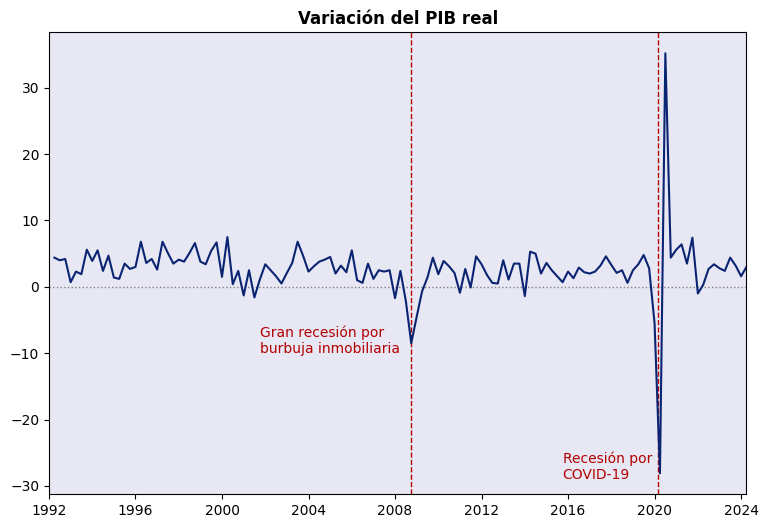

In [123]:
plt.figure(figsize = (9, 6))
plt.axhline(0, color = 'grey', linestyle = 'dotted', linewidth = 1)
plt.axvline(datetime(2020, 3, 1), color = '#b30000', linestyle = '--', linewidth = 1)
plt.axvline(datetime(2008, 10, 1), color = '#b30000', linestyle = '--', linewidth = 1)
plt.plot(dataframe['date'], dataframe['GDPv'], color = '#0A2472', linewidth = 1.5, marker = '')
plt.text(datetime(2001, 10, 1), -10, 'Gran recesión por\nburbuja inmobiliaria', color = '#b30000')
plt.text(datetime(2015, 10, 1), -29, 'Recesión por\nCOVID-19', color = '#b30000')
plt.gca().set_xlim(xmin = datetime(1992, 1, 1), xmax = dataframe['date'].iloc[-1])
plt.title('Variación del PIB real', fontweight = 'bold')
plt.rcParams['axes.facecolor'] = '#E8E8F5'

### Atributos

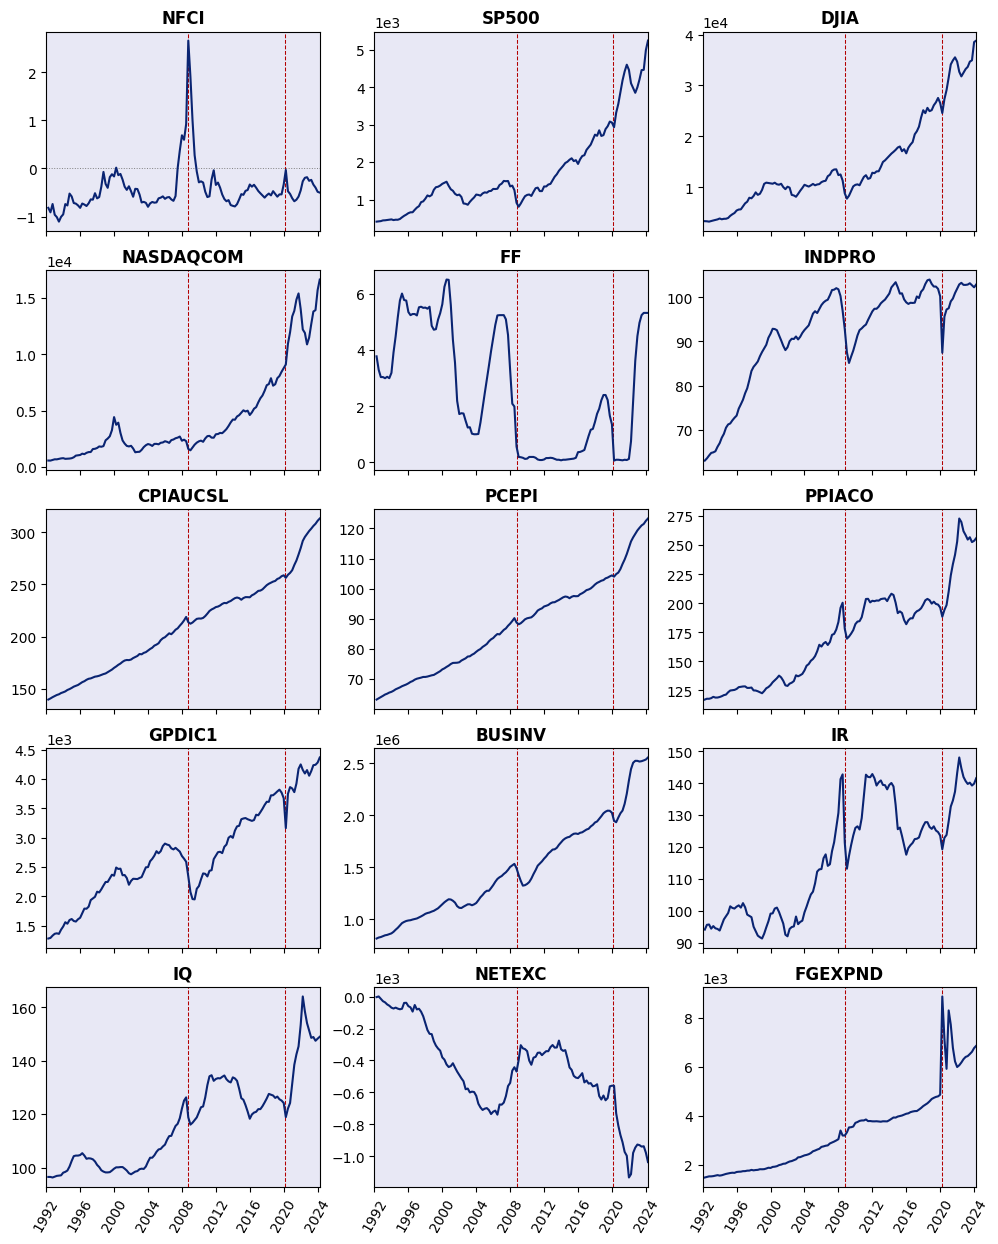

In [121]:
gridsize = (5, 3)
plt.figure(figsize = (12, 15))

for i in range(15):
    make_subplot(gridsize, (int(i / 3), i % 3), i, i in (12, 13, 14))

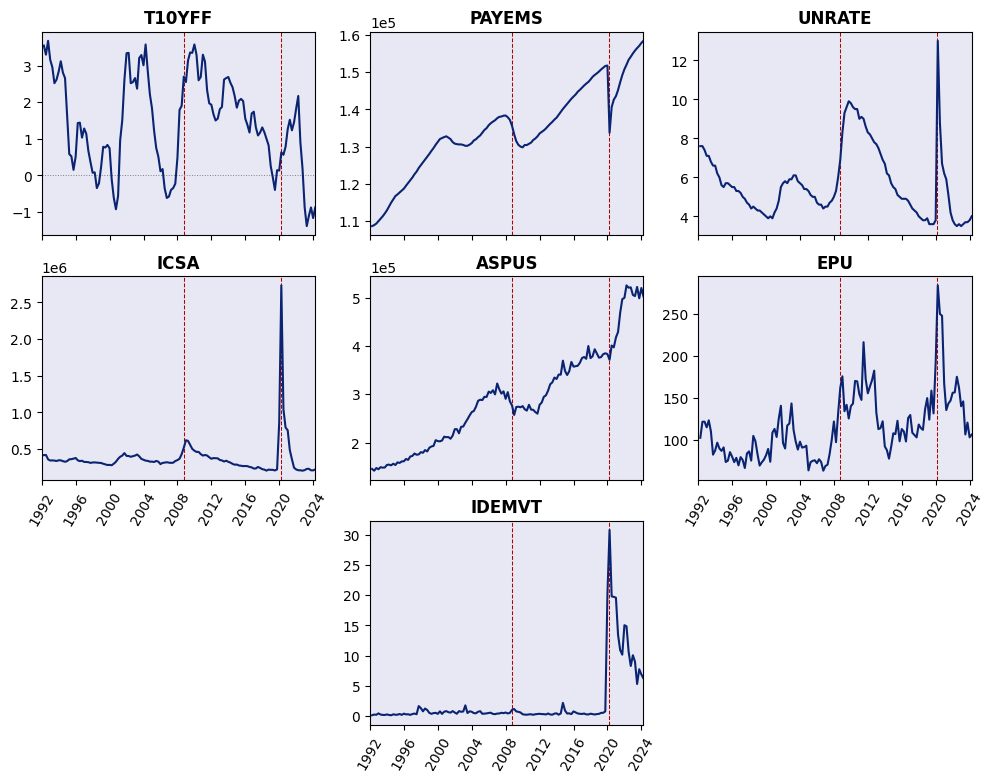

In [120]:
gridsize = (3, 3)
plt.figure(figsize = (12, 9))

for i in np.arange(15, 21):
    make_subplot(gridsize, (int((i - 15)/ 3), i % 3), i, int(i) in (18, 20))
make_subplot(gridsize, (int((21 - 15)/ 3), 1), 21, True)

### Riesgos

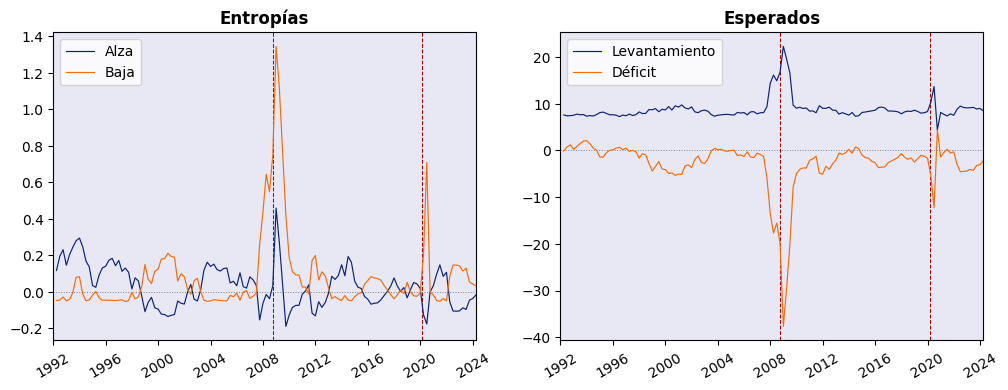

In [118]:
risks = pd.read_csv(os.getcwd() + '\\Risks\\complete_risks.csv')
risks['date'] = pd.to_datetime(risks['date'], format='%d/%m/%Y')
gridsize = (1, 2)
plt.figure(figsize = (12, 4))

ax60 = plt.subplot2grid(gridsize, (0, 0))
ax60.axhline(0, color = 'grey', linestyle = 'dotted', linewidth = 0.7)
ax60.axvline(datetime(2020, 3, 1), color = '#b30000', linestyle = '--', linewidth = 0.75)
ax60.axvline(datetime(2008, 10, 1), color = '#b30000', linestyle = '--', linewidth = 0.75)
ax60.plot(risks['date'], risks['entrpy.up'], color = '#0A2472', linewidth = 0.85, label = 'Alza')
ax60.plot(risks['date'], risks['entrpy.down'], color = '#FC6A03', linewidth = 0.85, label = 'Baja')
ax60.tick_params(axis = 'x', labelrotation = 30)
ax60.set_xlim(xmin = datetime(1992, 1, 1), xmax = dataframe['date'].iloc[-1])
ax60.set_title('Entropías', fontweight = 'bold')
ax60.set_facecolor('#E8E8F5')
ax60.legend().get_frame().set_facecolor('white')

ax61 = plt.subplot2grid(gridsize, (0, 1))
ax61.axhline(0, color = 'grey', linestyle = 'dotted', linewidth = 0.7)
ax61.axvline(datetime(2020, 3, 1), color = '#b30000', linestyle = '--', linewidth = 0.75)
ax61.axvline(datetime(2008, 10, 1), color = '#b30000', linestyle = '--', linewidth = 0.75)
ax61.plot(risks['date'], risks['longrise'], color = '#0A2472', linewidth = 0.85, label = 'Levantamiento')
ax61.plot(risks['date'], risks['shortfall'], color = '#FC6A03', linewidth = 0.85, label = 'Déficit')
ax61.tick_params(axis = 'x', labelrotation = 30)
ax61.set_xlim(xmin = datetime(1992, 1, 1), xmax = dataframe['date'].iloc[-1])
ax61.set_title('Esperados', fontweight = 'bold')
ax61.set_facecolor('#E8E8F5')
ax61.legend().get_frame().set_facecolor('white')

### Otras

#### Regresión lineal simple

coef:  [[0.89277532]]
intercept:  [4.92525139]


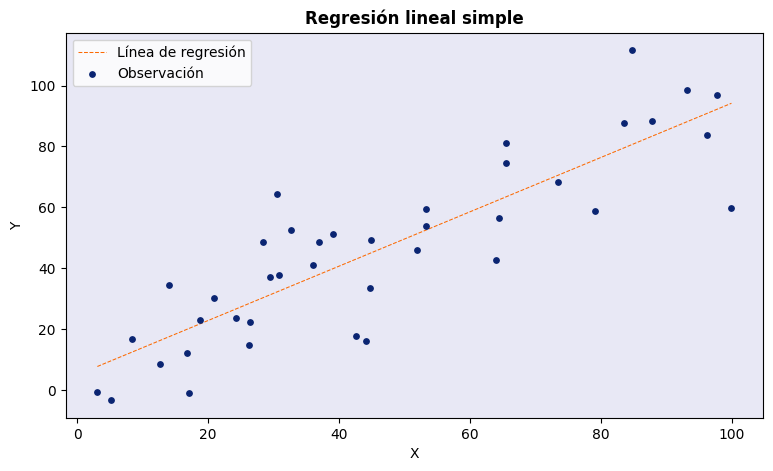

In [115]:
from sklearn.linear_model import LinearRegression

X = np.random.uniform(0, 100, size = 40)
Y = []
for x in X:
    Y.append(x + np.random.normal(0, 20))
X = X.reshape((-1, 1))
Y = np.array(Y)
Y = Y.reshape((-1, 1))
lin_reg = LinearRegression().fit(X, Y)
graph_line = lin_reg.predict(X)

plt.figure(figsize = (9, 5))
plt.plot(np.sort(np.squeeze(X)), np.sort(np.squeeze(graph_line)), label = 'Línea de regresión',
         linestyle = '--', linewidth = 0.75, color = '#FC6A03', zorder = -1)
plt.scatter(X, Y, s = 15, color = '#0A2472', label = 'Observación')
plt.title('Regresión lineal simple', fontweight = 'bold')
plt.xlabel('X')
plt.ylabel('Y')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'
print('coef: ', lin_reg.coef_)
print('intercept: ', lin_reg.intercept_)

#### Regresión cuantílica

Quantile  0.1  with intercept  7.567135487549576  and coefficient  [0.52162813]
Quantile  0.5  with intercept  8.54782839621255  and coefficient  [0.57243342]
Quantile  0.9  with intercept  10.52340473275187  and coefficient  [0.87445659]


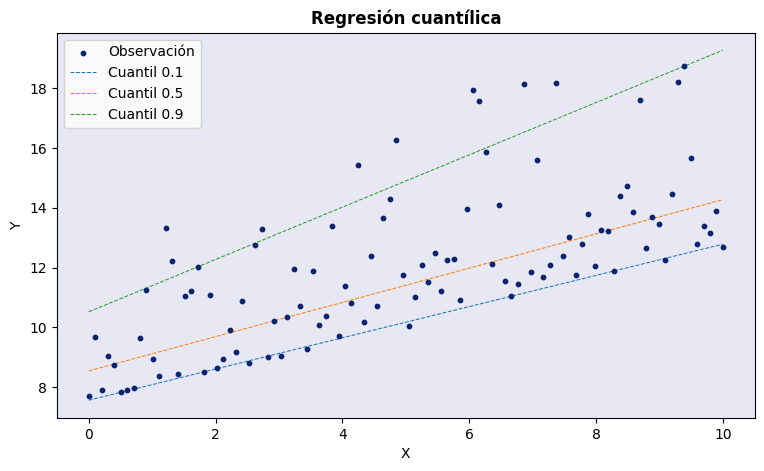

In [114]:
from sklearn.linear_model import QuantileRegressor

x = np.linspace(start = 0, stop = 10, num = 100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x
Y = y_true_mean + 10 * (np.random.pareto(5, size = X.shape[0]) - 1 / 4)
quantiles = [0.1, 0.5, 0.9]
predictions = {}
for quantile in quantiles:
    qr = QuantileRegressor(quantile = quantile, alpha = 0)
    y_pred = qr.fit(X, Y).predict(X)
    predictions[quantile] = y_pred
    print('Quantile ', quantile, ' with intercept ', qr.intercept_, ' and coefficient ', qr.coef_)

plt.figure(figsize = (9, 5))
plt.scatter(X, Y, s = 10, label = 'Observación', color = '#0A2472', zorder = 4)
for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label = f'Cuantil {quantile}', linestyle = '--', linewidth = 0.75)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Regresión cuantílica', fontweight = 'bold')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'

#### Distribuciones

<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
C:\Users\IvanCanto\AppData\Local\Temp\ipykernel_6328\57225219.py:6: SyntaxWarning: invalid escape sequence '\i'


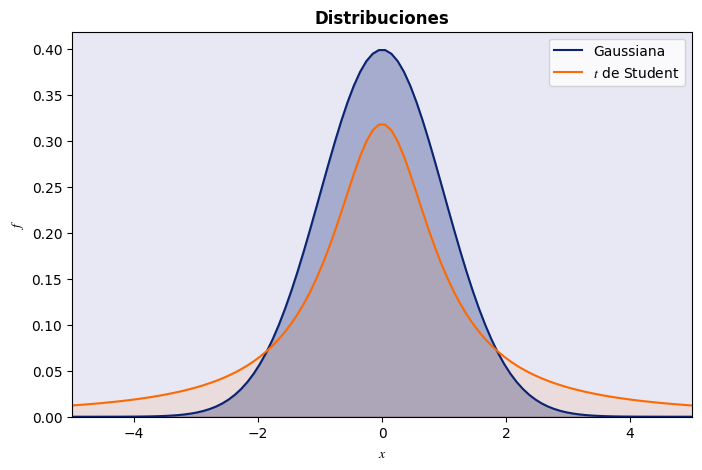

In [96]:
import scipy.stats as stats

x = np.linspace(-5, 5, 100)
plt.figure(figsize = (8, 5))
plt.plot(x, stats.norm.pdf(x, 0, 1), color = '#0A2472', label = 'Gaussiana')
plt.plot(x, stats.t.pdf(x, 1, 0), color = '#FC6A03', label = '$\it{t}$ de Student')
plt.fill_between(x = x, y1 = stats.norm.pdf(x, 0, 1), color = '#0A2472', alpha = 0.3)
plt.fill_between(x = x, y1 = stats.t.pdf(x, 1, 0), color = '#FC6A03', alpha = 0.1)
plt.title('Distribuciones', fontweight = 'bold')
ax = plt.gca()
ax.set_xlim(xmin = -5, xmax = 5)
ax.set_ylim(ymin = 0)
plt.xlabel('$x$')
plt.ylabel('$f$')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'

#### Riesgos replicados

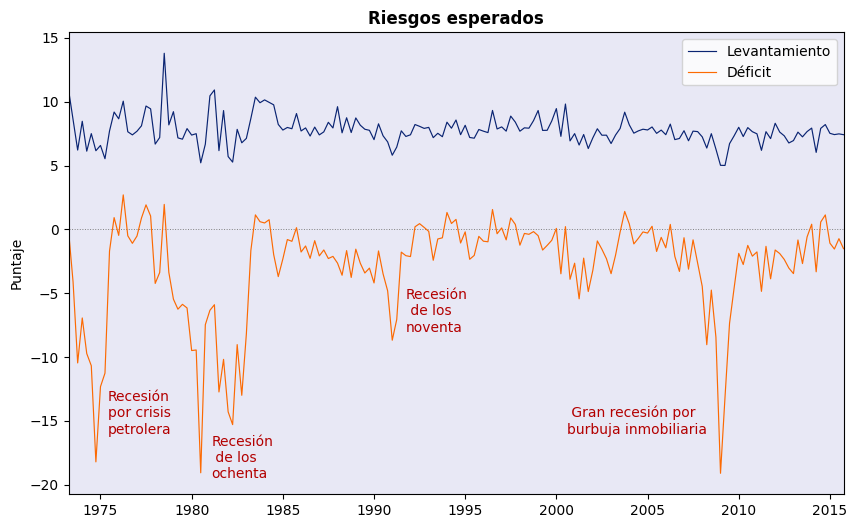

In [94]:
rep_risks = pd.read_csv(os.getcwd() + '\\Risks\\Replication\\replicated_risks.csv')
rep_risks['date'] = pd.to_datetime(rep_risks['date'], format='%Y-%m-%d')
plt.figure(figsize = (10, 6))

plt.axhline(0, color = 'grey', linestyle = 'dotted', linewidth = 0.7)
plt.plot(rep_risks['date'], rep_risks['longrise_L'], color = '#0A2472', linewidth = 0.85,
          label = 'Levantamiento')
plt.plot(rep_risks['date'], rep_risks['shortfall_L'], color = '#FC6A03', linewidth = 0.85,
          label = 'Déficit')
#plt.axvline(datetime(2008, 10, 1), color = '#b30000', linestyle = '--', linewidth = 0.75)
plt.text(datetime(2000, 8, 1), -16, ' Gran recesión por\nburbuja inmobiliaria', color = '#b30000')
#plt.axvline(datetime(1973, 11, 1), color = '#b30000', linestyle = '--', linewidth = 0.75)
plt.text(datetime(1975, 6, 1), -16, 'Recesión\npor crisis\npetrolera', color = '#b30000')
#plt.axvline(datetime(1980, 1, 1), color = '#b30000', linestyle = '--', linewidth = 0.75)
plt.text(datetime(1981, 2, 1), -19.5, 'Recesión\n de los\nochenta', color = '#b30000')
#plt.axvline(datetime(1990, 7, 1), color = '#b30000', linestyle = '--', linewidth = 0.75)
plt.text(datetime(1991, 10, 1), -8, 'Recesión\n de los\nnoventa', color = '#b30000')
ax = plt.gca()
ax.set_xlim(xmin = datetime(1973, 4, 1), xmax = rep_risks['date'].iloc[-1])
plt.title('Riesgos esperados', fontweight = 'bold')
plt.ylabel('Puntaje')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'

#### Descenso del gradiente

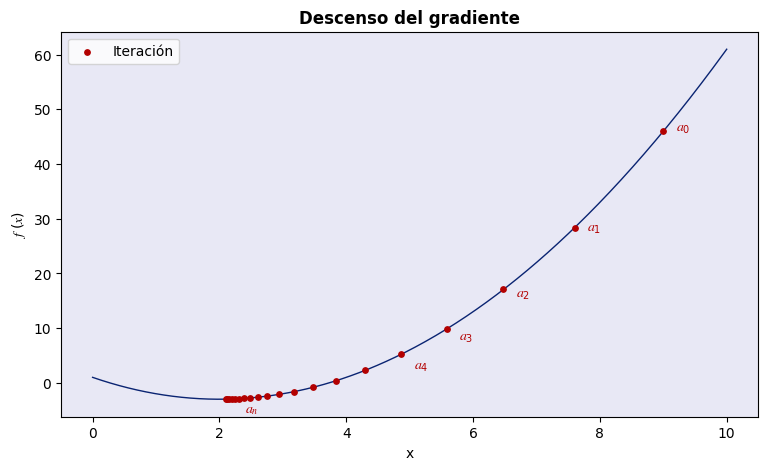

In [92]:
from scipy.interpolate import make_interp_spline

X = np.arange(0, 11)
Y = []
for x in X:
    Y.append(x**2 - 4*x + 1)

X_Y_Spline = make_interp_spline(X, Y)
X = np.linspace(X.min(), X.max(), 500)
Y = X_Y_Spline(X)

XX = [9]
for i in np.arange(1, 20):
    newx = XX[i - 1] - 0.1*(2 * XX[i - 1] - 4)
    XX.append(newx)

YY = []
for x in XX:
    YY.append(x**2 - 4*x + 1)

plt.figure(figsize = (9, 5))
plt.plot(X, Y, linewidth = 1, color = '#0A2472', zorder = -1)
plt.scatter(XX, YY, s = 15, color = '#b30000', label = 'Iteración')
plt.title('Descenso del gradiente', fontweight = 'bold')
for i in np.arange(0, 5):
    plt.text(XX[i] + 0.2, YY[i] - i * 0.7, '$a_' + str(i) + '$', color = '#b30000')
plt.text(XX[16] + 0.2, YY[16] - 2.5, '$a_n$', color = '#b30000')
plt.xlabel('x')
plt.ylabel('$f$ $(x)$')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'

#### Polynomial regression

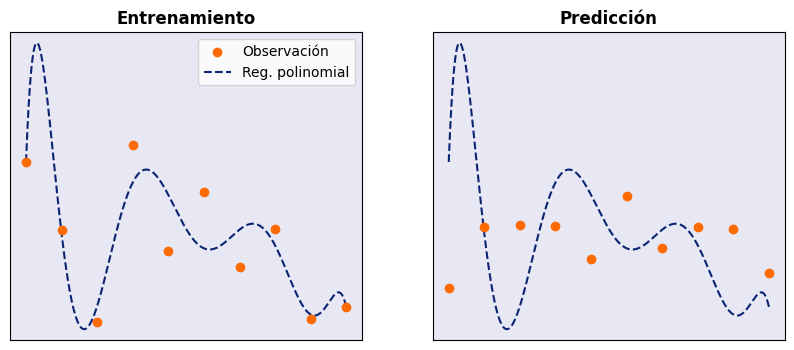

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

x = np.arange(10)
poly = PolynomialFeatures(degree = 8, interaction_only = False, include_bias = False)
x_poly = poly.fit_transform(x.reshape(-1, 1))
y = np.random.random(10)

pol_reg = LinearRegression().fit(x_poly, y)

myline = np.linspace(start = 0, stop = 9, num = 1000)

lame_reg = LinearRegression().fit(x.reshape(-1, 1), y)
nline = np.linspace(0, 9, 10)

newline = []
for i in range(len(lame_reg.predict(nline.reshape(-1, 1)))):
    newline.append(lame_reg.predict(nline.reshape(-1, 1))[i] + np.random.normal(0, 0.2))

gridsize = (1, 2)
plt.figure(figsize = (10, 4))

ax1 = plt.subplot2grid(gridsize, (0, 0))
ax1.scatter(x, y, color = '#FC6A03', label = 'Observación')
ax1.plot(myline, pol_reg.predict(poly.fit_transform(myline.reshape(-1, 1))), color = '#0A2472',
         linestyle = '--', label = 'Reg. polinomial', zorder = -1)
ax1.set_ylim(ymin = min([min(y),
                         min(np.squeeze(pol_reg.predict(poly.fit_transform(myline.reshape(-1, 1))))),
                         min(np.squeeze(newline))]) - 0.05,
             ymax = max([max(y),
                         max(np.squeeze(pol_reg.predict(poly.fit_transform(myline.reshape(-1, 1))))),
                         max(np.squeeze(newline))]) + 0.05)
ax1.set_title('Entrenamiento', fontweight = 'bold')
ax1.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
ax1.tick_params(axis = 'y', which = 'both', left = False, right = False, labelleft = False)
ax1.set_facecolor('white')
ax1.legend().get_frame().set_facecolor('white')
ax1.set_facecolor('#E8E8F5')


ax2 = plt.subplot2grid(gridsize, (0, 1))
ax2.scatter(nline, newline, color = '#FC6A03', label = 'Observación')
ax2.plot(myline, pol_reg.predict(poly.fit_transform(myline.reshape(-1, 1))), color = '#0A2472',
         linestyle = '--', label = 'Reg. polinomial', zorder = -1)
ax2.set_ylim(ymin = min([min(y),
                         min(np.squeeze(pol_reg.predict(poly.fit_transform(myline.reshape(-1, 1))))),
                         min(np.squeeze(newline))]) - 0.05,
             ymax = max([min(y),
                         max(np.squeeze(pol_reg.predict(poly.fit_transform(myline.reshape(-1, 1))))),
                         max(np.squeeze(newline))]) + 0.05)
ax2.set_title('Predicción', fontweight = 'bold')
ax2.set_facecolor('#E8E8F5')
ax2.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
ax2.tick_params(axis = 'y', which = 'both', left = False, right = False, labelleft = False)

#### KCV

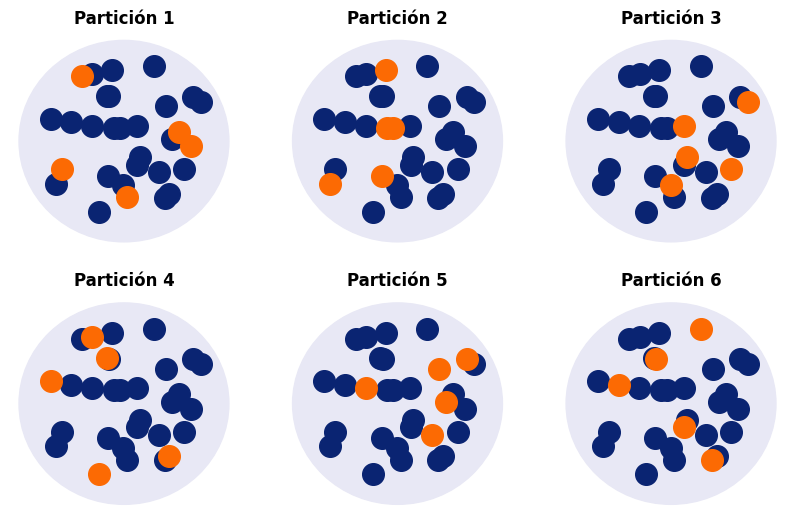

In [87]:
X = []
Y = []
circle_r = 1
circle_x = 0
circle_y = 0
for _ in range(30):
    alpha = 2 * np.pi * np.random.random()
    r = circle_r * np.sqrt(np.random.random())
    x = r * np.cos(alpha) + circle_x
    y = r * np.sin(alpha) + circle_y
    X.append(x)
    Y.append(y)
X = np.array(X)
Y = np.array(Y)

partitions = []
for i, (xx, yy) in enumerate(KFold(n_splits = 6).split(X)):
    partitions.append((xx, yy))

gridsize = (2, 3)
plt.figure(figsize = (10, 6.25))
plt.rcParams['axes.facecolor'] = 'white'

for i in range(6):
    ax = plt.subplot2grid(gridsize, (int(i / 3), i % 3))
    part, _ = partitions[i]
    xblue = X[part]
    yblue = Y[part]
    xorange = np.delete(X, part)
    yorange = np.delete(Y, part)
    dist = []
    for j in range(len(X)):
        dist.append(X[j]**2 + Y[j]**2)
    max_r = max(dist)
    max_index = dist.index(max_r)
    radius = np.sqrt(X[max_index]**2 + Y[max_index]**2) + 0.2
    circle = plt.Circle((0, 0), radius, color = '#E8E8F5')
    ax.add_patch(circle)
    ax.scatter(xblue, yblue, color = '#0A2472', s = 20*4**1.8, zorder = 1)
    ax.scatter(xorange, yorange, color = '#FC6A03', s = 20*4**1.8, zorder = 2)
    ax.set_ylim(- (radius + 0.1), radius + 0.1)
    ax.set_xlim(- (radius + 0.1), radius + 0.1)
    ax.set_title('Partición ' + str(i + 1), fontweight = 'bold')
    ax.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
    ax.tick_params(axis = 'y', which = 'both', left = False, right = False, labelleft = False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

#### KCVB

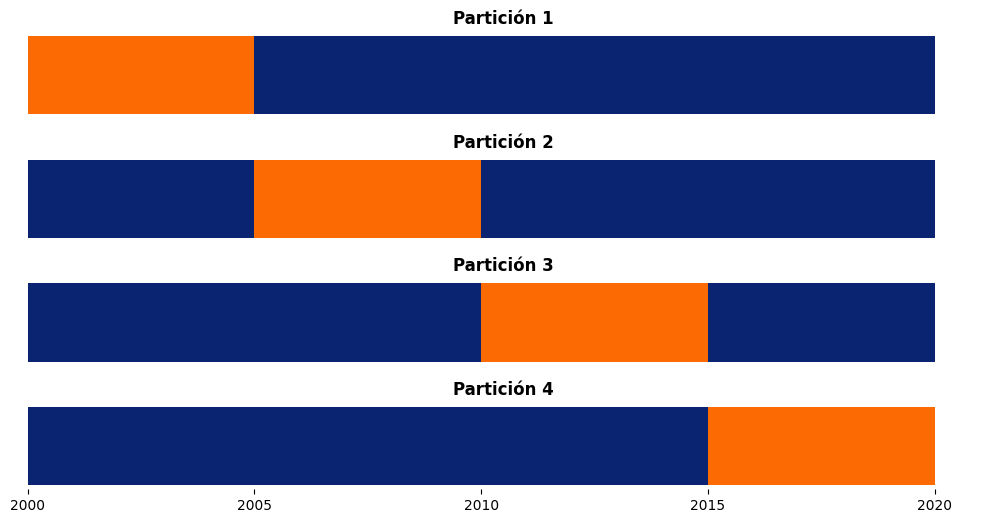

In [202]:
gridsize = (4, 1)
plt.figure(figsize = (10, 16/3), layout = 'tight')

ax0 = plt.subplot2grid(gridsize, (0, 0))
values = [1, 3]
colors = ['#FC6A03', '#0A2472']
ax0.barh([0], values[0], color = colors[0], height = 0.1, align = 'center')
ax0.barh([0], values[1], color = colors[1], height = 0.1, align = 'center', left = values[0])
ax0.axis('off')
ax0.set_title('Partición ' + str(1), fontweight = 'bold')

ax1 = plt.subplot2grid(gridsize, (1, 0))
values = [1, 1, 2]
ax1.barh([0], values[0], color = colors[1], height = 0.1, align = 'center')
ax1.barh([0], values[1], color = colors[0], height = 0.1, align = 'center', left = values[0])
ax1.barh([0], values[2], color = colors[1], height = 0.1, align='center', left = values[0] + values[1])
ax1.axis('off')
ax1.set_title('Partición ' + str(2), fontweight = 'bold')

ax2 = plt.subplot2grid(gridsize, (2, 0))
values = [2, 1, 1]
ax2.barh([0], values[0], color = colors[1], height = 0.1, align = 'center')
ax2.barh([0], values[1], color = colors[0], height = 0.1, align = 'center', left = values[0])
ax2.barh([0], values[2], color = colors[1], height = 0.1, align = 'center', left = values[0] + values[1])
ax2.axis('off')
ax2.set_title('Partición ' + str(3), fontweight = 'bold')

ax3 = plt.subplot2grid(gridsize, (3, 0))
values = [3, 1]
ax3.barh([0], values[0], color = colors[1], height = 0.1, align = 'center')
ax3.barh([0], values[1], color = colors[0], height = 0.1, align = 'center', left = values[0])
ax3.set_title('Partición ' + str(4), fontweight = 'bold')

ax3.tick_params(axis = 'y', which = 'both', left = False, right = False, labelleft = False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_xticks(np.array([0, 1, 2, 3, 4]), ['2000', '2005', '2010', '2015', '2020'])

#### Partition

Text(100.5, 0, 'Entrenamiento')

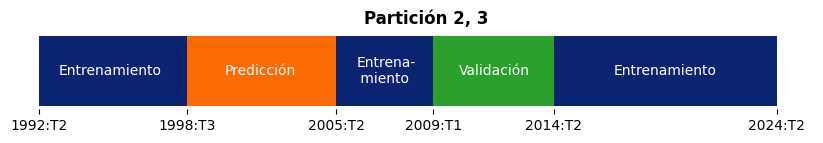

In [53]:
plt.figure(figsize = (10, 1))

colors = ['#0A2472', '#FC6A03', '#2ca02c']
values = [26, 26, 17, 21, 39]

plt.barh([0], values[0], color = colors[0], height = 0.1, align = 'center')
plt.barh([0], values[1], color = colors[1], height = 0.1, align = 'center', left = values[0])
plt.barh([0], values[2], color = colors[0], height = 0.1, align = 'center',
         left = values[0] + values [1])
plt.barh([0], values[3], color = colors[2], height = 0.1, align = 'center',
         left = values[0] + values [1] + values [2])
plt.barh([0], values[4], color = colors[0], height = 0.1, align = 'center',
         left = values[0] + values [1] + values [2] + values [3])
plt.title('Partición 2, 3', fontweight = 'bold')

ax = plt.gca()

ax.tick_params(axis = 'y', which = 'both', left = False, right = False, labelleft = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks(np.array([0, 26, 52, 69, 90, 129]), ['1992:T2', '1998:T3', '2005:T2', '2009:T1', '2014:T2', '2024:T2'])
ax.text(32.5, 0, 'Predicción', color = 'w', ha = 'left', va = 'center')
ax.text(73.5, 0, 'Validación', color = 'w', ha = 'left', va = 'center')
ax.text(3.5, 0, 'Entrenamiento', color = 'w', ha = 'left', va = 'center')
ax.text(55.5, 0, 'Entrena-\n miento', color = 'w', ha = 'left', va = 'center')
ax.text(100.5, 0, 'Entrenamiento', color = 'w', ha = 'left', va = 'center')

#### Parameters

Text(0, 0.5, '$\\nu$')

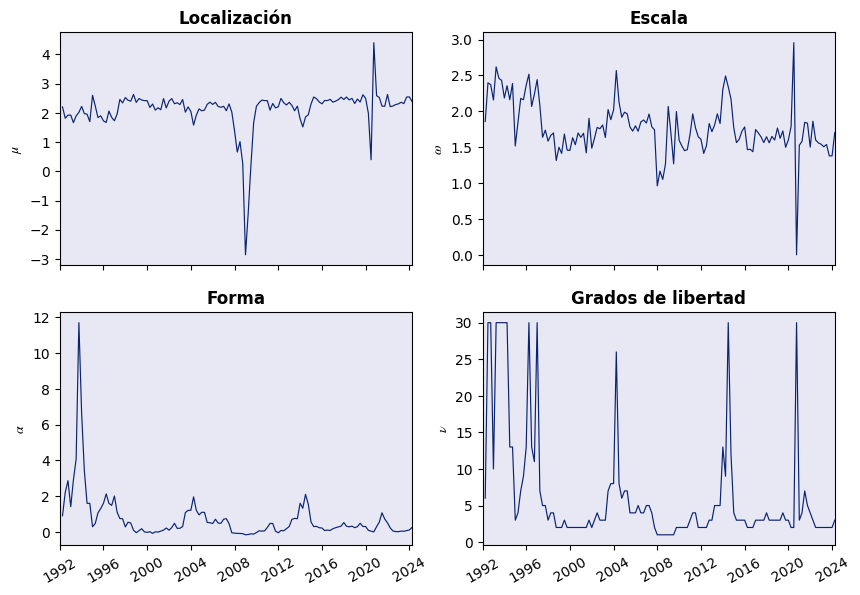

In [84]:
risks = pd.read_csv(os.getcwd() + '\\Risks\\complete_risks.csv')
risks['date'] = pd.to_datetime(risks['date'], format='%d/%m/%Y')
gridsize = (2, 2)
plt.figure(figsize = (10, 20/3))

ax00 = plt.subplot2grid(gridsize, (0, 0))
ax00.plot(risks['date'], risks['xi'], color = '#0A2472', linewidth = 0.85)
ax00.tick_params(axis = 'x', labelrotation = 30)
ax00.set_xlim(xmin = datetime(1992, 1, 1), xmax = dataframe['date'].iloc[-1])
ax00.set_title('Localización', fontweight = 'bold')
ax00.set_facecolor('#E8E8F5')
ax00.set_ylabel('$\\mu$')
ax00.xaxis.set_ticklabels([])

ax01 = plt.subplot2grid(gridsize, (0, 1))
ax01.plot(risks['date'], risks['omega'], color = '#0A2472', linewidth = 0.85)
ax01.tick_params(axis = 'x', labelrotation = 30)
ax01.set_xlim(xmin = datetime(1992, 1, 1), xmax = dataframe['date'].iloc[-1])
ax01.set_title('Escala', fontweight = 'bold')
ax01.set_facecolor('#E8E8F5')
ax01.set_ylabel('$\\omega$')
ax01.xaxis.set_ticklabels([])

ax10 = plt.subplot2grid(gridsize, (1, 0))
ax10.plot(risks['date'], risks['alpha'], color = '#0A2472', linewidth = 0.85)
ax10.tick_params(axis = 'x', labelrotation = 30)
ax10.set_xlim(xmin = datetime(1992, 1, 1), xmax = dataframe['date'].iloc[-1])
ax10.set_title('Forma', fontweight = 'bold')
ax10.set_facecolor('#E8E8F5')
ax10.set_ylabel('$\\alpha$')

ax11 = plt.subplot2grid(gridsize, (1, 1))
ax11.plot(risks['date'], risks['nu'], color = '#0A2472', linewidth = 0.85)
ax11.tick_params(axis = 'x', labelrotation = 30)
ax11.set_xlim(xmin = datetime(1992, 1, 1), xmax = dataframe['date'].iloc[-1])
ax11.set_title('Grados de libertad', fontweight = 'bold')
ax11.set_facecolor('#E8E8F5')
ax11.set_ylabel('$\\nu$')


#### Moving average

<Figure size 900x500 with 0 Axes>

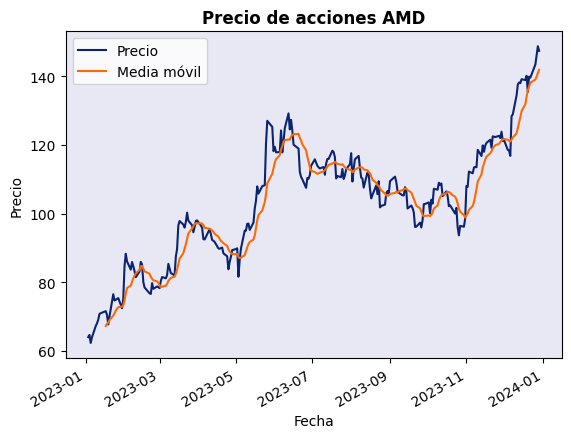

In [82]:
import yfinance as yf

plt.figure(figsize = (9, 5))
AMD = yf.Ticker('AMD')
AMD_values = AMD.history(start = '2023-01-01', end = '2024-01-01')
AMD_values['Media móvil'] = AMD_values['Close'].rolling(10).mean()
AMD_values['Precio'] = AMD_values['Close']
AMD_values[['Precio', 'Media móvil']].plot(color = ('#0A2472', '#FC6A03'))

plt.title('Precio de acciones AMD', fontweight = 'bold')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'

#### LSTM predictive power

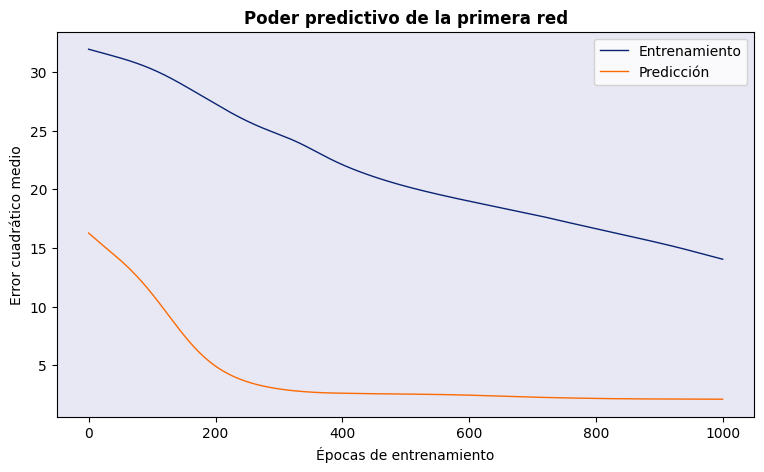

In [14]:
score = pd.read_csv(os.getcwd() + '\\metrics_' + str(0) + '.csv')
plt.figure(figsize = (9, 5))
plt.plot(score['epoch'], score['train_MSE'], linewidth = 1, color = '#0A2472', zorder = -1, label = 'Entrenamiento')
plt.plot(score['epoch'], score['test_MSE'], linewidth = 1, color = '#FC6A03', zorder = 1, label = 'Predicción')
plt.title('Poder predictivo de la primera red', fontweight = 'bold')
plt.xlabel('Épocas de entrenamiento')
plt.ylabel('Error cuadrático medio')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'

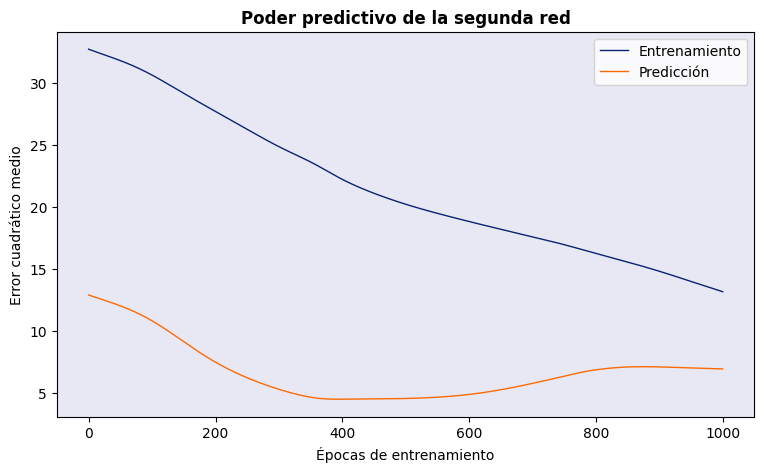

In [15]:
score = pd.read_csv(os.getcwd() + '\\metrics_' + str(1) + '.csv')
plt.figure(figsize = (9, 5))
plt.plot(score['epoch'], score['train_MSE'], linewidth = 1, color = '#0A2472', zorder = -1, label = 'Entrenamiento')
plt.plot(score['epoch'], score['test_MSE'], linewidth = 1, color = '#FC6A03', zorder = 1, label = 'Predicción')
plt.title('Poder predictivo de la segunda red', fontweight = 'bold')
plt.xlabel('Épocas de entrenamiento')
plt.ylabel('Error cuadrático medio')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'

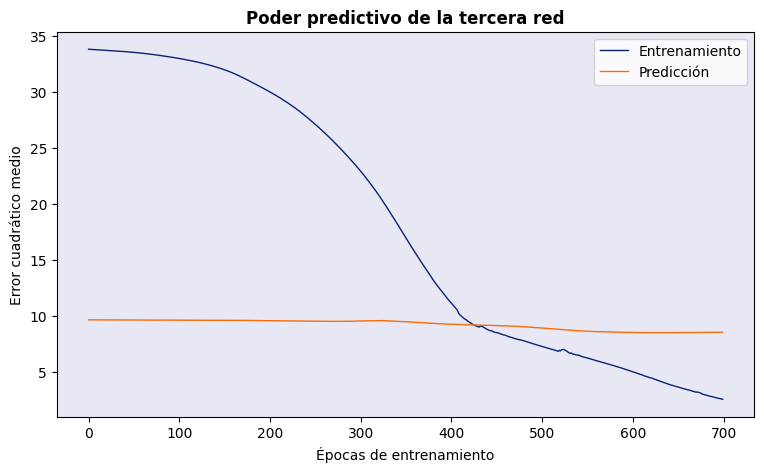

In [16]:
score = pd.read_csv(os.getcwd() + '\\metrics_' + str(2) + '.csv')
plt.figure(figsize = (9, 5))
plt.plot(score['epoch'], score['train_MSE'], linewidth = 1, color = '#0A2472', zorder = -1, label = 'Entrenamiento')
plt.plot(score['epoch'], score['test_MSE'], linewidth = 1, color = '#FC6A03', zorder = 1, label = 'Predicción')
plt.title('Poder predictivo de la tercera red', fontweight = 'bold')
plt.xlabel('Épocas de entrenamiento')
plt.ylabel('Error cuadrático medio')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'

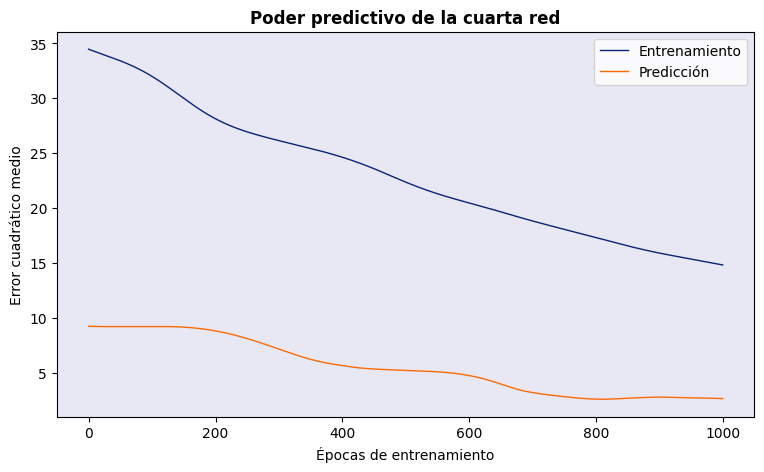

In [17]:
score = pd.read_csv(os.getcwd() + '\\metrics_' + str(3) + '.csv')
plt.figure(figsize = (9, 5))
plt.plot(score['epoch'], score['train_MSE'], linewidth = 1, color = '#0A2472', zorder = -1, label = 'Entrenamiento')
plt.plot(score['epoch'], score['test_MSE'], linewidth = 1, color = '#FC6A03', zorder = 1, label = 'Predicción')
plt.title('Poder predictivo de la cuarta red', fontweight = 'bold')
plt.xlabel('Épocas de entrenamiento')
plt.ylabel('Error cuadrático medio')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'

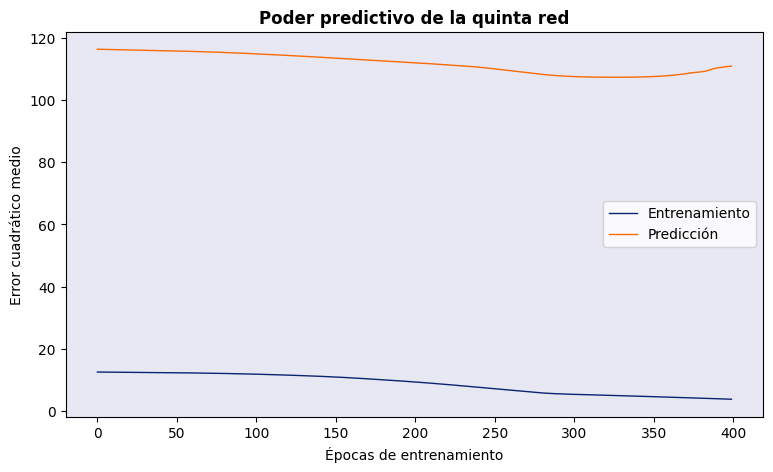

In [18]:
score = pd.read_csv(os.getcwd() + '\\metrics_' + str(4) + '.csv')
plt.figure(figsize = (9, 5))
plt.plot(score['epoch'], score['train_MSE'], linewidth = 1, color = '#0A2472', zorder = -1, label = 'Entrenamiento')
plt.plot(score['epoch'], score['test_MSE'], linewidth = 1, color = '#FC6A03', zorder = 1, label = 'Predicción')
plt.title('Poder predictivo de la quinta red', fontweight = 'bold')
plt.xlabel('Épocas de entrenamiento')
plt.ylabel('Error cuadrático medio')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'

#### Estimación $t$ sesgada

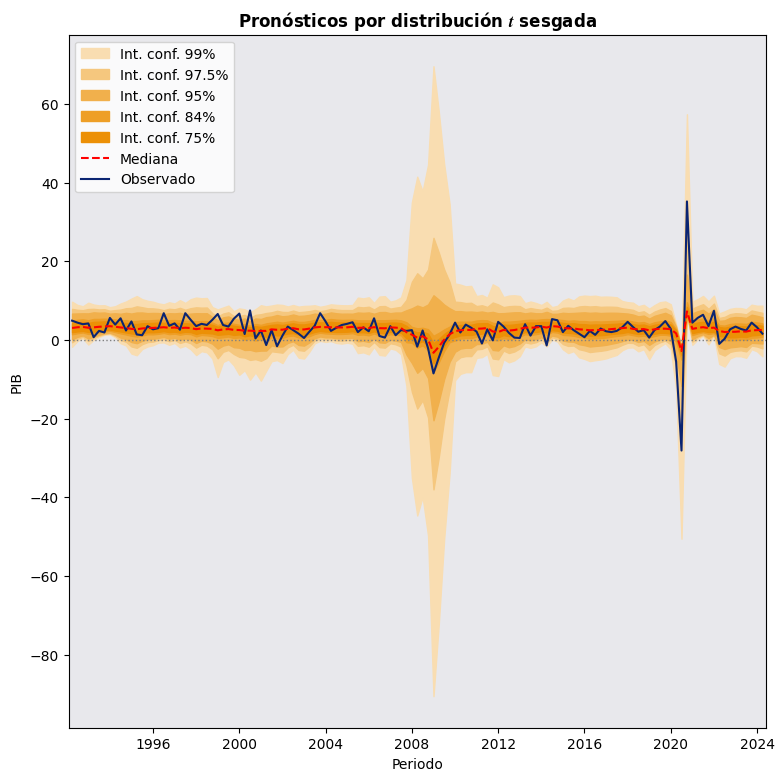

In [76]:
from matplotlib.pyplot import *
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'STIXGeneral:italic'
rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'

plt.figure(figsize = (9, 9))
plt.fill_between(dataframe['date'], risk_ints['I0.01'], risk_ints['I0.99'], color = '#F9DDB1', zorder = -6, label = 'Int. conf. 99%')
plt.fill_between(dataframe['date'], risk_ints['I0.025'], risk_ints['I0.975'], color = '#F5C77E', zorder = -5, label = 'Int. conf. 97.5%')
plt.fill_between(dataframe['date'], risk_ints['I0.05'], risk_ints['I0.95'], color = '#F1B04C', zorder = -4, label = 'Int. conf. 95%')
plt.fill_between(dataframe['date'], risk_ints['I0.16'], risk_ints['I0.84'], color = '#EE9F27', zorder = -3, label = 'Int. conf. 84%')
plt.fill_between(dataframe['date'], risk_ints['I0.25'], risk_ints['I0.75'], color = '#EC9006', zorder = -2, label = 'Int. conf. 75%')
plt.axhline(0, color = 'grey', linestyle = 'dotted', linewidth = 1, zorder = -2)
plt.plot(dataframe['date'], risk_targets, linewidth = 1.5, color = 'red', zorder = 1, linestyle = '--', label = 'Mediana')
plt.plot(dataframe['date'], targets, linewidth = 1.5, color = '#0A2472', zorder = -1, label = 'Observado')
ax = plt.gca()
ax.set_xlim(xmin = datetime(1992, 2, 1), xmax = datetime(2024, 6, 1))
plt.title('Pronósticos por distribución ' + r'$\mathbf{t}$' + ' sesgada', fontweight = 'bold')
plt.xlabel('Periodo')
plt.ylabel('PIB')
plt.rcParams['axes.facecolor'] = 'white'
plt.legend()
plt.rcParams['axes.facecolor'] = '#E8E8F5'